| Student | ID | Email |
|-----------|-----------|-----------|
| Mattia Buzzoni         | 0001145667| mattia.buzzoni@studio.unibo.it       |
| Riccardo Romeo         | 0001145681| riccardo.romeo@studio.unibo.it       |
| Mirko Mornelli         | 0001113084| mirko.mornelli@studio.unibo.it       |

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Callable
import torch
from torchsummary import summary
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import utils

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Is the GPU available? True
Device: cuda


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

## Imports

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
import random
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

## Solution Part 1

### Preprocessing

We need a simple dictionary which maps the number of a class with its name.

In [ ]:
dict_num_classes = {
    0: 'Apple',
    1: 'Avocado',
    2: 'Banana',
    3: 'Kiwi',
    4: 'Lemon',
    5: 'Lime',
    6: 'Mango',
    7: 'Melon',
    8: 'Nectarine',
    9: 'Orange',
    10: 'Papaya',
    11: 'Passion-Fruit',
    12: 'Peach',
    13: 'Pear',
    14: 'Pineapple',
    15: 'Plum',
    16: 'Pomegranate',
    17: 'Red-Grapefruit',
    18: 'Satsumas',
    19: 'Juice',
    20: 'Milk',
    21: 'Oatghurt',
    22: 'Oat-Milk',
    23: 'Sour-Cream',
    24: 'Sour-Milk',
    25: 'Soyghurt',
    26: 'Soy-Milk',
    27: 'Yoghurt',
    28: 'Asparagus',
    29: 'Aubergine',
    30: 'Cabbage',
    31: 'Carrots',
    32: 'Cucumber',
    33: 'Garlic',
    34: 'Ginger',
    35: 'Leek',
    36: 'Mushroom',
    37: 'Onion',
    38: 'Pepper',
    39: 'Potato',
    40: 'Red-Beet',
    41: 'Tomato',
    42: 'Zucchini'
}

Now, we want to compute the standard deviation and the mean for each channel of the images in the dataset. Those values will be used in the following transformers.

In [ ]:
train_without_transformer = GroceryStoreDataset('train') # training
val_without_transformer = GroceryStoreDataset('val')  # validation
test_without_transformer = GroceryStoreDataset('test') # test

In [ ]:
def get_mean_std(dataset):
    img_red_means = []
    img_green_means = []
    img_blue_means = []

    img_red_stds = []
    img_green_stds = []
    img_blue_stds = []

    for index in range(len(dataset)):
        # Load the image and convert it to a NumPy array
        image = np.array(dataset[index][0])

        image = image / 255.0

        # Calculate mean for each channel
        mean_red = np.mean(image[:, :, 0])
        mean_green = np.mean(image[:, :, 1])
        mean_blue = np.mean(image[:, :, 2])

        img_red_means.append(mean_red)
        img_green_means.append(mean_green)
        img_blue_means.append(mean_blue)

        # Calculate standard deviation for each channel
        std_red = np.std(image[:, :, 0])
        std_green = np.std(image[:, :, 1])
        std_blue = np.std(image[:, :, 2])

        img_red_stds.append(std_red)
        img_green_stds.append(std_green)
        img_blue_stds.append(std_blue)

    # Calculate the overall mean and standard deviation
    mean_red = np.mean(img_red_means)
    mean_green = np.mean(img_green_means)
    mean_blue = np.mean(img_blue_means)

    mean_image_net = [round(mean_red, 2), round(mean_green, 2), round(mean_blue, 2)]

    std_red = np.mean(img_red_stds)
    std_green = np.mean(img_green_stds)
    std_blue = np.mean(img_blue_stds)

    std_image_net = [round(std_red, 2), round(std_green, 2), round(std_blue, 2)]

    return mean_image_net, std_image_net

In [ ]:
mean_image_net, std_image_net = get_mean_std(train_without_transformer)
print(f'The mean of RGB channels is: {mean_image_net}')
print(f'The standard deviation of RGB channels is: {std_image_net}')

The mean of RGB channels is: [0.53, 0.4, 0.26]
The standard deviation of RGB channels is: [0.23, 0.21, 0.18]


### Denormalizer

Obviously, we need a denormalizer which is able to denormalize out images in the dataset.

In [ ]:
class NormalizeInverse(T.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


def show_grid(dataset: GroceryStoreDataset, dictionary, process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset[idx][1]
        for key, value in dictionary.items():
          if title == key:
            title = value
            break
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(T.ToPILImage()(image_processed))
        plt.axis("off")

    fig.suptitle('A bunch of images', fontsize=16, color='orange')
    plt.tight_layout()
    plt.show()

### Trainer

In the following section we show the trainer that we used for our entire development. In particular, note that we are going to use the cross entropy loss function.

In [ ]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_loader, epochs, opt, scheduler, val_loader=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_loader:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use
            scheduler.step()

        train_acc /= train_samples
        train_loss /= train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():   # No need to calculate gradients
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_loader is not None:
                for val_data in val_loader:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

            if val_loader is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_loader is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {(100*train_acc):.2f}%" +
                  ("" if val_loader is None else f" - valid loss {val_loss:.3f} - valid acc {(100*val_acc):.2f}%"))

    if verbose and val_loader is not None:
        print(f"\nBest epoch: {best_epoch}, best acc: {(100*best_val_acc):.2f}%")

    # Return metrics for plotting
    return best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies

### Tester

Naturally, we also need a tester which will be able to test the model behaviour on the test set.

In [ ]:
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_samples = 0
    test_acc = 0
    with torch.no_grad():  # Disable gradient calculations
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            test_samples += images.shape[0]
            outputs = model(images)
            test_acc += ncorrect(outputs, labels).item()
        test_acc /= test_samples

    print(f'Accuracy of the network on the test images: {(100*test_acc):.2f}%')

### Plotting function

The following function will be used only in order to plot our model metrics. In this way we will be able to visualize the model's behaviour during the training period.

In [ ]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=''):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, '-', label='Train Loss')
    plt.plot(epochs, val_losses, '-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, '-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, '-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Set the overall title for the figure
    plt.suptitle(title, fontsize=16, color='red')

    plt.tight_layout()
    plt.show()

### Hyperparameters

In this section we create a dictionary that will envelope all the hyperparameters we are going to use.

In [ ]:
# Hyperparameters

cfg = {
    "resize_size": 345,
    "crop_size": 224,
    "degrees": 20,

    "batch_size": 296,
    "num_epochs": 30,

    "lr": 1e-3,
    "wd": 1e-4,

    'drop_out_rate': 0.35
}

### Trasformer

Now, we can build our first transformer.

In our first attempts we want to try to perform several transformation on our dataset. In particular:


*   We need to resize all the images in order to don't put in input images with a huge resolution;
*   We also normalize our images witht he means and standard devitions we computed above;
*   We also want to try to perform a cropping of the images. Note that it is not true that the cropping is always able to give us better images. In fact, we could also obtain some images no more coherent with the labels;
*   We perform some transformations those are not a problem with our dataset, i.e. flips and rotations.



In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    T.RandomResizedCrop(cfg['crop_size']),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(cfg['degrees'])
])



Then, we can create our train, test and val datasets.

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

### Input Images

In [ ]:
input_dim = len(train[0][0])
print(f"Input dimension channels: {input_dim}")

Input dimension channels: 3


Following we can see how our images appear after the transformations.

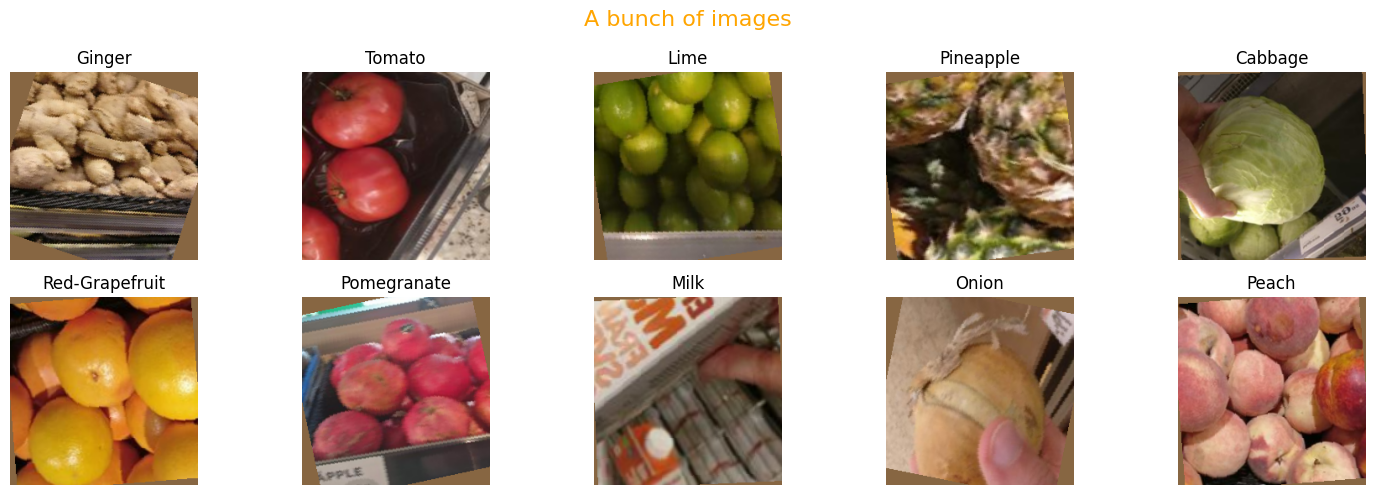

In [ ]:
denormalize = NormalizeInverse(mean_image_net, std_image_net)
show_grid(val, dict_num_classes, process=denormalize)

It's possible to see that in some cases due to the crop, the images are not so coherent with labels. We will deal with this aspect later in the notebook.

### Data loaders

At this point, we create our train, test and val dataloaders.

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 8
Number of batches in the val set: 1
Number of batches in the test set: 8


### Feature maps visualizer

This function will be used just in order to visualize the feature maps of a trained model. It is usefull in order to understand the behaviour of our model.

In [ ]:
def visualize_feature_maps(model, input_image, layer_names):
    model.to(device)

    input_image = input_image.to(device)

    model.eval()

    feature_maps = []

    def get_feature_maps(module, input, output):
        feature_maps.append(output)

    hooks = []
    for name in layer_names:
        layer = dict(model.named_modules())[name]
        hook = layer.register_forward_hook(get_feature_maps)
        hooks.append(hook)

    with torch.no_grad():
        _ = model(input_image)

    plt.figure(figsize=(5, 5))

    img = input_image[0].cpu().permute(1, 2, 0)

    # Normalzation of the image
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img.clamp(0, 1))
    plt.title('Input Image', color='red', fontsize=16)
    plt.axis('off')
    plt.show()
    print('\n')

    # feature maps visualization
    for i, fmap in enumerate(feature_maps):
        num_feature_maps = fmap.size(1)
        selected_indices = random.sample(range(num_feature_maps), min(16, num_feature_maps))  # We select 16 random feature maps
        plt.figure(figsize=(15, 15))
        for j, idx in enumerate(selected_indices):  # we show only the selected feature maps
            plt.subplot(4, 4, j + 1)
            plt.imshow(fmap[0, idx].cpu().numpy(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Layer {layer_names[i]}: {len(selected_indices)} feature maps', color='red', fontsize=26)
        plt.show()
        print('\n')

    # Removing hooks
    for hook in hooks:
        hook.remove()

In [ ]:
# We select a random image from the test set in order to visualize the features maps of our model
data_iter = iter(test_loader)
images, _ = next(data_iter)
random_index = random.randint(0, images.size(0) - 1)
input_image = images[random_index].unsqueeze(0)
layer_names = [
    'bn1',
    'bn2',
    'bn6'
]

### The Model

In order to solve the task we tried several models. But, the model that presented the best performances is the following one.

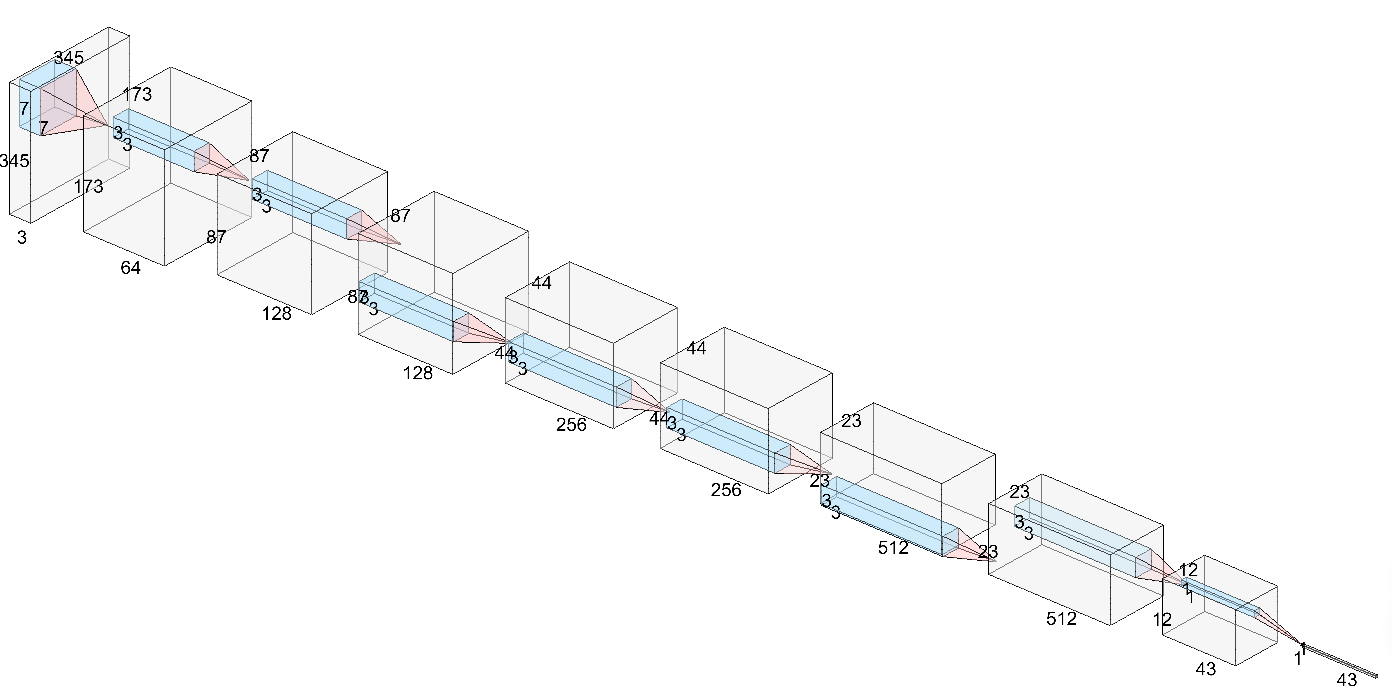

Let's talk a little bit about this model.

First of all, we need to display the blocks of this model. we thought of building the model based on the repetition of pre-established blocks, as was done for Inception and ResNets.

Here each block presents the following structure:

*   Convolution -> BN -> Convolution -> BN -> MaxPooling

The first block represents an exception since it consists only of a convolution with kernel 7x7 (stride 2 and padding 3), followed by a BN and a Max Pooling operation.

Note that, due to the Clarifai teaching we didn't use at the beginning a convolution with a kernel of 11x11 (like in AlexNet). We decided to do so in order to don't have "dead neurons" in first layers. In fact, we used exactly the same convolution used in Clarifai: 7x7 conv with stride 2.

While, inside out blocks, we used always 3x3 convs with stride 1 and padding 1.

But what distinguishes the model we are about to present is the classifier. Note that at the end of our model, we do not have any Fully Connected Layer. This "weird" decision has been taken after several tries.

Initially, we made a model that presented those blocks and at the end, and Average Pooling operation in order to interface the features extractor with the classifier.

Now, during our study we saw that is possible to directly use an Average Pooling layer as classfier instead of using FC layers. In this way we should be able to maintain spatial context and also, we are able to drastically reduce the number of parameters we need. In particular we link this:

*   https://www.quora.com/How-can-we-build-a-convolutional-neural-network-CNN-without-any-fully-connected-layers;
*   https://arxiv.org/abs/2004.13587.

But, there is an issue in using an Average Pooling as classfier: we need a layer that outputs a number of channels equal to the number of classes of our classification task. This is why we put that "strange" 1x1 convolutional layer before the Average Pooling Classifier.


Note also that, due to the fact that we don't have FC layers in our model we cannot use the "usual" dropout:


*   [What happens if I use dropout after convolutional layer? Does that affects features maps?](https://www.quora.com/What-happens-if-I-use-dropout-after-convolutional-layer-Does-that-affects-features-maps#:~:text=Dropout%20acts%20as%20way%20of,it%20is%20likely%20to%20overfit.)
*   [Dropout on convolutional layers is weird](https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2)


In particular we saw that we could use a 2D Dropout instead. By the [pythorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html) we saw that in order to regularize activations we have to put this kind of dropout on the last convolutions because it's probable that near pixels to be correlated.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, use_batch_norm=True, use_dropout=True, dropout_prob=0.2):
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.pool1 = nn.MaxPool2d(3, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.pool2 = nn.MaxPool2d(3, 2, 1)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()
        self.pool3 = nn.MaxPool2d(3, 2, 1)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512) if use_batch_norm else nn.Identity()
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(512) if use_batch_norm else nn.Identity()
        self.pool4 = nn.MaxPool2d(3, 2, 1)

        self.conv8 = nn.Conv2d(512, num_classes, kernel_size=1)  # Conv 1x1
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        if use_dropout:
            self.dropout = nn.Dropout2d(dropout_prob)
        else:
            self.dropout = nn.Identity()

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.conv3(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(x)))

        x = self.conv5(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x) if self.use_dropout else x
        x = self.pool3(F.relu(self.bn5(x)))


        x = self.conv7(F.relu(self.bn6(self.conv6(x))))
        x = self.dropout(x) if self.use_dropout else x
        x = self.pool4(F.relu(self.bn7(x)))

        x = F.relu(self.conv8(x))

        x = self.global_pool(x)
        x = torch.flatten(x, 1)

        return x

Now, checking the code above: we entroduced two flags in the constructor of our model. Those flags are useful in order to impose the usage of Batch Normalization and/or Dropout.

To recap:


*   The first part of the model is able to reduce the spatial dimension,
exactly like a stem layer would do;
*   Then we have 3 blocks (with the structure presented above);
*   After those blocks we use a convolutional 1x1 layer just in order to interface the feature extractor with the "classifier";
*   As classifer we decided to experiment something unusual, an Average Pooling Classifier.



A note about the training process: in all our attempts we used as optimizer AdamW and a One Cycle scheduler.

### Performances without Batch Normalization and without Dropout

First of all, we would like to test our model behviour without any Batch Normalization process and without Dropout.

In this way we will be able to understand if one of those techniques is necessary for this task.

In [ ]:
cfg['num_epochs'] = 65

In [ ]:
model = Model(num_classes = num_classes, use_batch_norm = False, use_dropout = False, dropout_prob = cfg['drop_out_rate'])

for name, params in model.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
conv7.weight torch.Size([512, 512, 3, 3])
conv7.bias torch.Size([512])
conv8.weight torch.Size([43, 512, 1, 1])
conv8.bias torch.Size([43])


In [ ]:
torch.cuda.empty_cache()
model.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): Identity()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): Identity()
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): Identity()
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): Identity()
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): Identity()
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): Identity()
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn7): Identity()
  (pool4): MaxPool2d(kernel_size=3, stride=2, 

In [ ]:
summary(model, input_size=(3, cfg['crop_size'], cfg['crop_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
          Identity-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
          Identity-5          [-1, 128, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]         147,584
          Identity-7          [-1, 128, 56, 56]               0
         MaxPool2d-8          [-1, 128, 28, 28]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
         Identity-10          [-1, 256, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]         590,080
         Identity-12          [-1, 256, 28, 28]               0
        MaxPool2d-13          [-1, 256, 14, 14]               0
           Conv2d-14          [-1, 512,

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 0: train loss 3.746 - train acc 10.77% - valid loss 3.730 - valid acc 7.43%
Epoch 1: train loss 3.663 - train acc 10.68% - valid loss 3.547 - valid acc 7.43%
Epoch 2: train loss 3.494 - train acc 10.85% - valid loss 3.476 - valid acc 9.80%
Epoch 3: train loss 3.464 - train acc 7.85% - valid loss 3.528 - valid acc 9.80%
Epoch 4: train loss 3.442 - train acc 9.80% - valid loss 3.489 - valid acc 12.16%
Epoch 5: train loss 3.397 - train acc 12.88% - valid loss 3.396 - valid acc 9.80%
Epoch 6: train loss 3.212 - train acc 17.23% - valid loss 3.302 - valid acc 12.16%
Epoch 7: train loss 3.116 - train acc 16.89% - valid loss 3.261 - valid acc 14.53%
Epoch 8: train loss 3.055 - train acc 18.41% - valid loss 3.192 - valid acc 17.91%
Epoch 9: train loss 2.985 - train acc 19.72% - valid loss 3.224 - valid acc 17.23%
Epoch 10: train loss 2.951 - train acc 23.23% - valid loss 3.154 - valid acc 18.58%
Epoch 11: train loss 2.916 - train acc 22.68% - valid loss 3.176 - valid acc 20.27%
Epoch 12:

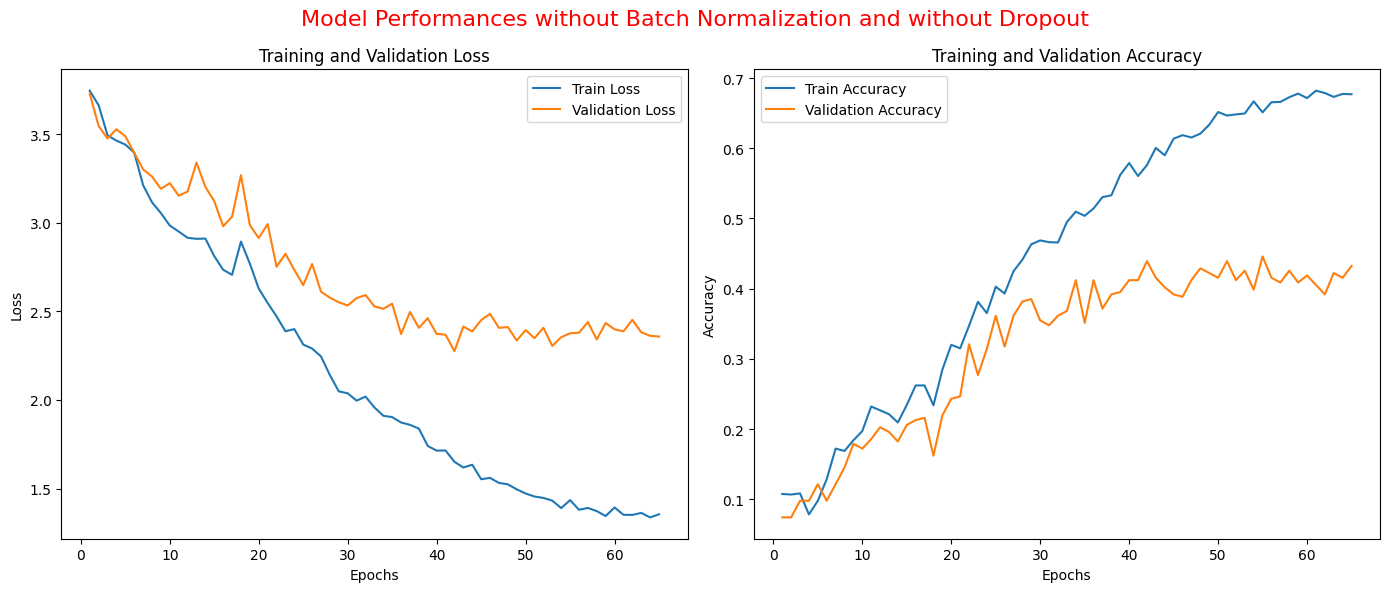

In [ ]:
title = 'Model Performances without Batch Normalization and without Dropout'
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model, test_loader, device)

Accuracy of the network on the test images: 52.28%


As we can see our model is not so good without any batch normalization nor dropout process. Thus, it's probable that we will need to implement the batch norm or dropout.

#### Feature maps

In [ ]:
##### UNCOMMENT THIS LINE IN ORDER TO VISUALIZE SOME FEATURE MAPS #####
# visualize_feature_maps(model, input_image, layer_names)

### Performances with Batch Normalization and without Dropout

Now, we are going to show that for this task and with this model we need to implement batch normalization in order to obtain a better accuracy.

In particular, we are going to use Batch Normalization without any Dropout.

In [ ]:
cfg['num_epochs'] = 57

In [ ]:
model_bn = Model(num_classes = num_classes, use_batch_norm = True, use_dropout = False, dropout_prob = cfg['drop_out_rate'])

for name, params in model_bn.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
bn3.weight torch.Size([128])
bn3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
bn5.weight torch.Size([256])
bn5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
bn6.weight torch.Size([512])
bn6.bias torch.Size([512])
conv7.weight torch.Size([512, 512, 3, 3])
conv7.bias torch.Size([512])
bn7.weight torch.Size([512])
bn7.bias torch.Size([512])
conv8.weight torch.Size([43, 512, 1, 1])
conv8.bias torch.Size([43])


In [ ]:
torch.cuda.empty_cache()
model_bn.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
summary(model_bn, input_size=(3, cfg['crop_size'], cfg['crop_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
       BatchNorm2d-5          [-1, 128, 56, 56]             256
            Conv2d-6          [-1, 128, 56, 56]         147,584
       BatchNorm2d-7          [-1, 128, 56, 56]             256
         MaxPool2d-8          [-1, 128, 28, 28]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 256, 28, 28]         590,080
      BatchNorm2d-12          [-1, 256, 28, 28]             512
        MaxPool2d-13          [-1, 256, 14, 14]               0
           Conv2d-14          [-1, 512,

In [ ]:
optimizer = torch.optim.AdamW(model_bn.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_bn, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 0: train loss 3.417 - train acc 15.12% - valid loss 3.753 - valid acc 1.35%
Epoch 1: train loss 2.854 - train acc 29.60% - valid loss 3.583 - valid acc 9.46%
Epoch 2: train loss 2.517 - train acc 36.99% - valid loss 3.243 - valid acc 17.91%
Epoch 3: train loss 2.223 - train acc 42.44% - valid loss 2.838 - valid acc 20.95%
Epoch 4: train loss 1.935 - train acc 49.37% - valid loss 2.524 - valid acc 33.45%
Epoch 5: train loss 1.735 - train acc 55.45% - valid loss 2.414 - valid acc 37.50%
Epoch 6: train loss 1.607 - train acc 58.40% - valid loss 2.133 - valid acc 40.88%
Epoch 7: train loss 1.444 - train acc 62.42% - valid loss 2.090 - valid acc 37.50%
Epoch 8: train loss 1.245 - train acc 67.23% - valid loss 2.161 - valid acc 40.54%
Epoch 9: train loss 1.166 - train acc 68.62% - valid loss 2.845 - valid acc 38.18%
Epoch 10: train loss 1.058 - train acc 71.49% - valid loss 2.294 - valid acc 39.19%
Epoch 11: train loss 1.000 - train acc 73.14% - valid loss 2.798 - valid acc 32.43%
Epoc

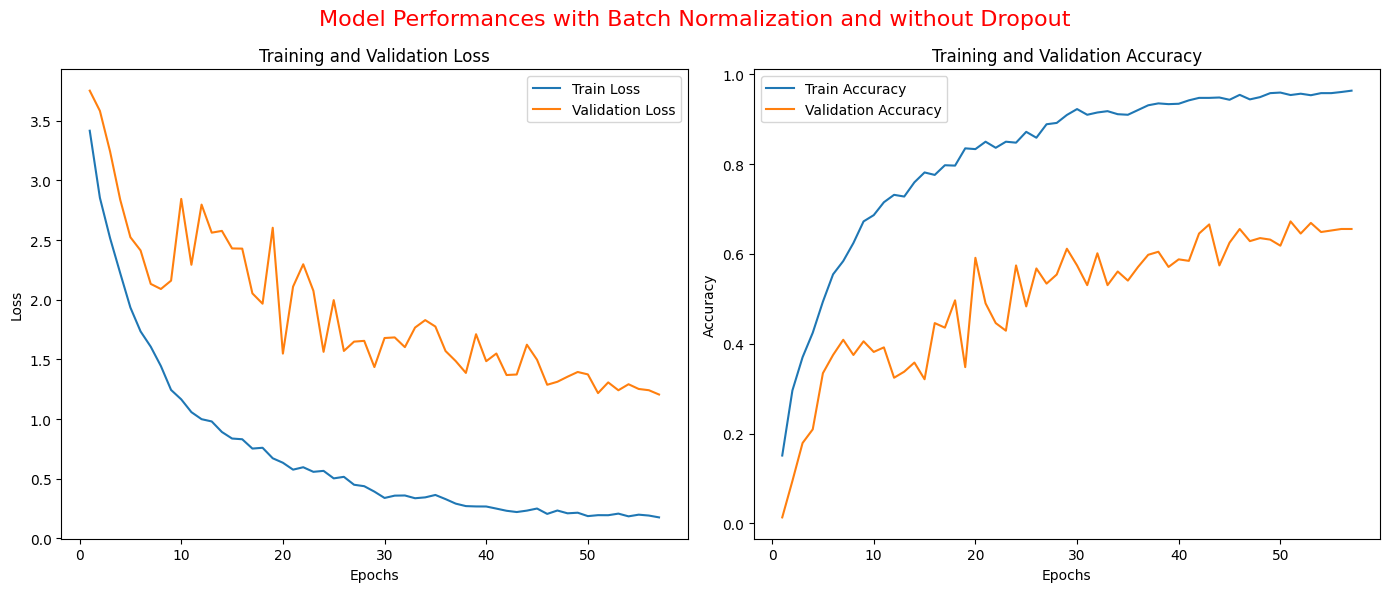

In [ ]:
title = 'Model Performances with Batch Normalization and without Dropout'
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_bn, test_loader, device)

Accuracy of the network on the test images: 72.51%


Using BAtch Normalization after our convolutional layers we are able to drastically increase the performances of our network. In particular, we are able to achieve an accuracy greater than 60%, as required in order to solve the task.

Because of these performances, we will use batch norm from now on.

#### Feature maps

In [ ]:
##### UNCOMMENT THIS LINE IN ORDER TO VISUALIZE SOME FEATURE MAPS #####
# visualize_feature_maps(model_bn, input_image, layer_names)

### Performances with Batch Normalization and with Dropout

We shown above that Batch Normalization is necessary in order to achieve better performances. In the following section, we would like to understand if Dropout could be useful in order to improve again the accuracy of our model.

In [ ]:
cfg['num_epochs'] = 65

In [ ]:
model_bn_do = Model(num_classes = num_classes, use_batch_norm = True, use_dropout = True, dropout_prob = cfg['drop_out_rate'])

for name, params in model_bn_do.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
bn3.weight torch.Size([128])
bn3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
bn5.weight torch.Size([256])
bn5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
bn6.weight torch.Size([512])
bn6.bias torch.Size([512])
conv7.weight torch.Size([512, 512, 3, 3])
conv7.bias torch.Size([512])
bn7.weight torch.Size([512])
bn7.bias torch.Size([512])
conv8.weight torch.Size([43, 512, 1, 1])
conv8.bias torch.Size([43])


In [ ]:
torch.cuda.empty_cache()
model_bn_do.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
summary(model_bn_do, input_size=(3, cfg['crop_size'], cfg['crop_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
       BatchNorm2d-5          [-1, 128, 56, 56]             256
            Conv2d-6          [-1, 128, 56, 56]         147,584
       BatchNorm2d-7          [-1, 128, 56, 56]             256
         MaxPool2d-8          [-1, 128, 28, 28]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 256, 28, 28]         590,080
        Dropout2d-12          [-1, 256, 28, 28]               0
      BatchNorm2d-13          [-1, 256, 28, 28]             512
        MaxPool2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.AdamW(model_bn_do.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_bn_do, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 0: train loss 3.620 - train acc 9.46% - valid loss 3.754 - valid acc 2.03%
Epoch 1: train loss 3.221 - train acc 18.29% - valid loss 3.674 - valid acc 7.77%
Epoch 2: train loss 2.927 - train acc 26.31% - valid loss 3.392 - valid acc 12.16%
Epoch 3: train loss 2.723 - train acc 31.29% - valid loss 3.237 - valid acc 13.85%
Epoch 4: train loss 2.532 - train acc 35.52% - valid loss 2.772 - valid acc 29.39%
Epoch 5: train loss 2.337 - train acc 38.81% - valid loss 2.650 - valid acc 27.70%
Epoch 6: train loss 2.137 - train acc 42.91% - valid loss 2.372 - valid acc 33.45%
Epoch 7: train loss 1.946 - train acc 47.55% - valid loss 2.564 - valid acc 32.43%
Epoch 8: train loss 1.840 - train acc 48.27% - valid loss 2.284 - valid acc 34.80%
Epoch 9: train loss 1.691 - train acc 51.82% - valid loss 2.181 - valid acc 40.20%
Epoch 10: train loss 1.599 - train acc 52.91% - valid loss 2.927 - valid acc 25.68%
Epoch 11: train loss 1.526 - train acc 55.95% - valid loss 2.113 - valid acc 34.80%
Epoch

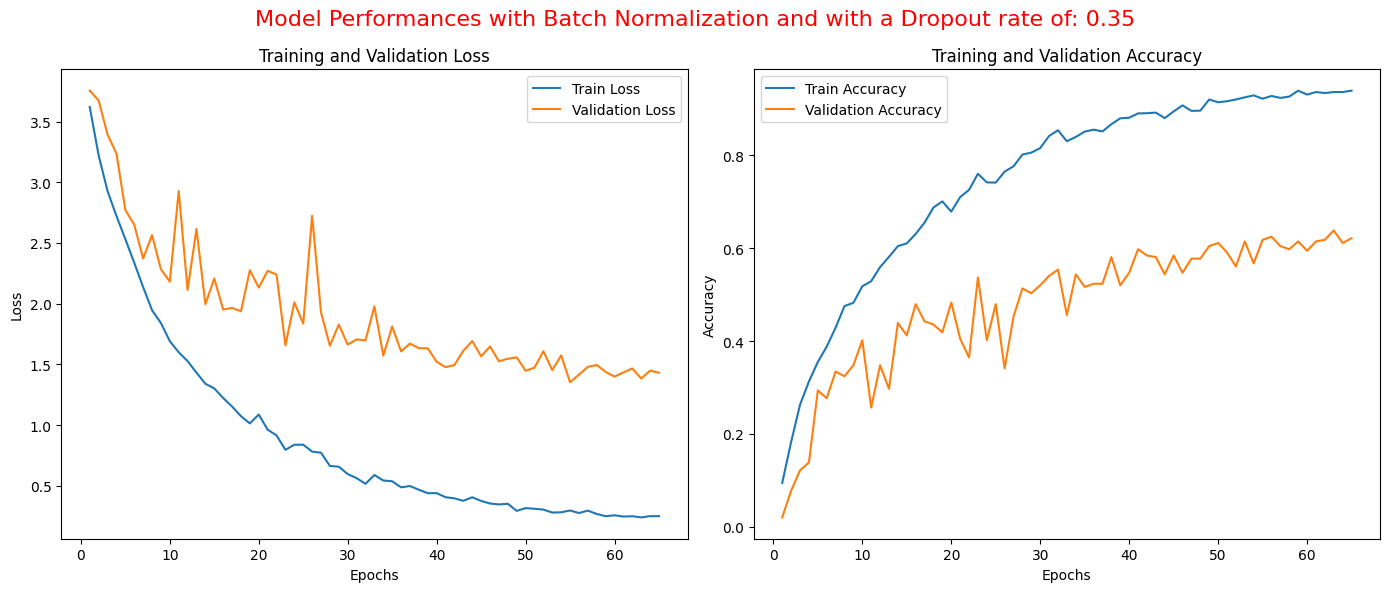

In [ ]:
title = f"Model Performances with Batch Normalization and with a Dropout rate of: {cfg['drop_out_rate']}"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_bn_do, test_loader, device)

Accuracy of the network on the test images: 72.85%


As we can see the usage of Dropout doesn't seem to lead to much better results. The Dropout value has been chosen after several attempts, and the value of 0.35 seems to be the best one.


However, in some training runs the dropout manages to make us reach one or two percentage points more accuracy, so for the next tests we will use it.

#### Feature maps

In [ ]:
##### UNCOMMENT THIS LINE IN ORDER TO VISUALIZE SOME FEATURE MAPS #####
# visualize_feature_maps(model_bn_do, input_image, layer_names)

### Performances with an additional block of layer composed by 2 conv2d and 1 batch norm without a conv 1x1 (to see if conv 1x1 can be replaced by an additional stage to reach better results)

In this section we want to show another experimental proof that the 1x1 convolutional layer is a good choice for our model.

In particular, we could think that in order to achieve better accuracies we could add another block instead of use that weird 1x1 convolutional layer as interfacer between blocks and the average pooling classifier.

So, the idea is to put away the 1x1 convolution and add another block which is able to give in output a number of channels equal to the number of classes, In thie way e could be able to directly interface the feature extractor with our unusual classifier.

In order to mke a fair comparison we are going to use the same characteristics used before. Thus, we will have the same optimizer, scheduler and hyperparameters. Note that we are going to use dropout and batch normalization.

In [ ]:
cfg['num_epochs'] = 85

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, use_batch_norm=True, use_dropout=False, dropout_prob=0.2):
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.pool1 = nn.MaxPool2d(3, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.pool2 = nn.MaxPool2d(3, 2, 1)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()
        self.pool3 = nn.MaxPool2d(3, 2, 1)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512) if use_batch_norm else nn.Identity()
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(512) if use_batch_norm else nn.Identity()
        self.pool4 = nn.MaxPool2d(3, 2, 1)

        self.conv8 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(1024) if use_batch_norm else nn.Identity()
        self.conv9 = nn.Conv2d(1024, num_classes, kernel_size=3, stride=1, padding=1)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        if use_dropout:
            self.dropout = nn.Dropout2d(dropout_prob)
        else:
            self.dropout = nn.Identity()

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.conv3(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(x)))

        x = self.conv5(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x) if self.use_dropout else x
        x = self.pool3(F.relu(self.bn5(x)))


        x = self.conv7(F.relu(self.bn6(self.conv6(x))))
        x = self.dropout(x) if self.use_dropout else x
        x = self.pool4(F.relu(self.bn7(x)))

        x = self.conv9(F.relu(self.bn8(self.conv8(x))))
        x = F.relu(x)

        x = self.global_pool(x)
        x = torch.flatten(x, 1)

        return x

In [ ]:
model_bn_do = Model(num_classes = num_classes, use_batch_norm = True, use_dropout = True, dropout_prob = cfg['drop_out_rate'])

for name, params in model_bn_do.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
bn3.weight torch.Size([128])
bn3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
bn5.weight torch.Size([256])
bn5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
bn6.weight torch.Size([512])
bn6.bias torch.Size([512])
conv7.weight torch.Size([512, 512, 3, 3])
conv7.bias torch.Size([512])
bn7.weight torch.Size([512])
bn7.bias torch.Size([512])
conv8.weight torch.Size([1024, 512, 3, 3])
conv8.bias torch.Size([1024])
bn8.weight torch.Size([1024])
bn8.bias torch.

In [ ]:
torch.cuda.empty_cache()
model_bn_do.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
summary(model_bn_do, input_size=(3, cfg['crop_size'], cfg['crop_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
       BatchNorm2d-5          [-1, 128, 56, 56]             256
            Conv2d-6          [-1, 128, 56, 56]         147,584
       BatchNorm2d-7          [-1, 128, 56, 56]             256
         MaxPool2d-8          [-1, 128, 28, 28]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 256, 28, 28]         590,080
        Dropout2d-12          [-1, 256, 28, 28]               0
      BatchNorm2d-13          [-1, 256, 28, 28]             512
        MaxPool2d-14          [-1, 256,

Now note that, adding another block, we obtained  more complex model, with an higher number of parameters. In particular, we need too much parameters in the last convolutional layer due to the number of channels.

On the other hand, we could be able to collect more features and obtain more representation.

In [ ]:
optimizer = torch.optim.AdamW(model_bn_do.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_bn_do, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/85 [00:00<?, ?it/s]

Epoch 0: train loss 3.554 - train acc 12.42% - valid loss 3.719 - valid acc 6.76%
Epoch 1: train loss 3.152 - train acc 20.73% - valid loss 3.642 - valid acc 6.76%
Epoch 2: train loss 2.945 - train acc 26.10% - valid loss 3.494 - valid acc 8.78%
Epoch 3: train loss 2.795 - train acc 29.90% - valid loss 3.151 - valid acc 18.58%
Epoch 4: train loss 2.616 - train acc 35.22% - valid loss 3.025 - valid acc 20.95%
Epoch 5: train loss 2.420 - train acc 38.51% - valid loss 3.031 - valid acc 29.39%
Epoch 6: train loss 2.267 - train acc 41.89% - valid loss 3.177 - valid acc 29.39%
Epoch 7: train loss 2.166 - train acc 44.59% - valid loss 3.072 - valid acc 30.74%
Epoch 8: train loss 2.102 - train acc 45.95% - valid loss 2.871 - valid acc 36.82%
Epoch 9: train loss 2.046 - train acc 47.13% - valid loss 3.581 - valid acc 34.80%
Epoch 10: train loss 2.008 - train acc 48.82% - valid loss 2.860 - valid acc 40.88%
Epoch 11: train loss 2.008 - train acc 49.32% - valid loss 2.956 - valid acc 30.07%
Epoch

As we can see, we should train the model for a great amount of epochs in order to achieve the accuracy we had before.

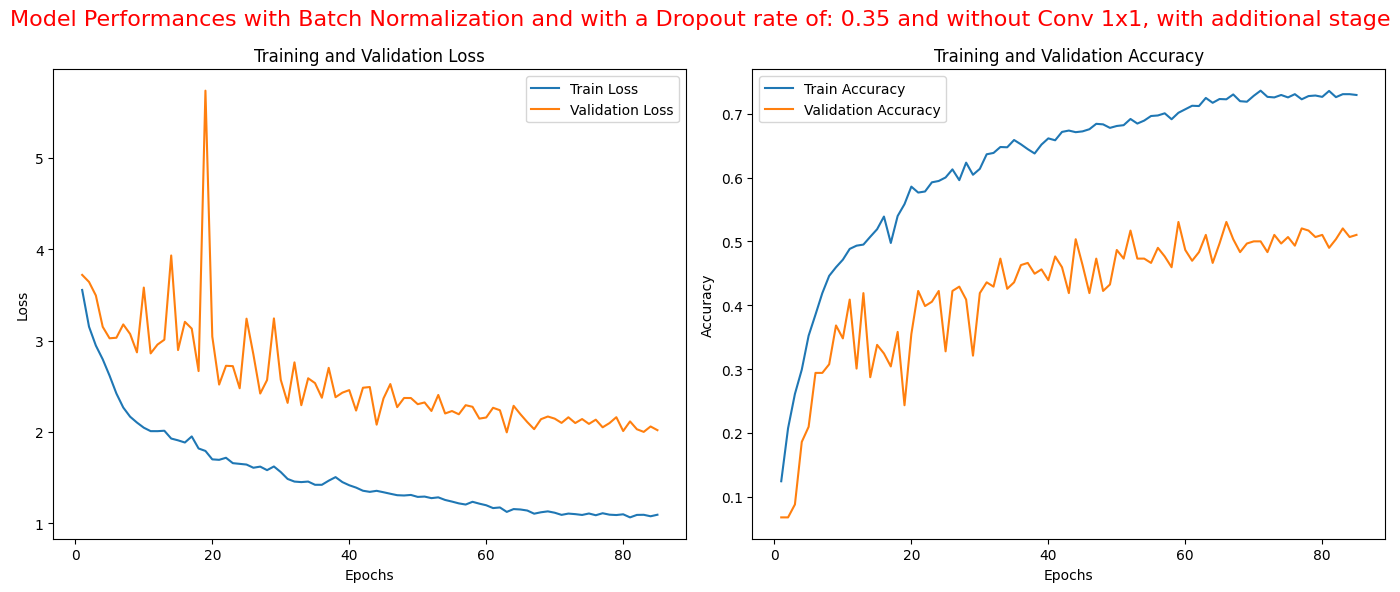

In [ ]:
title = f"Model Performances with Batch Normalization and with a Dropout rate of: {cfg['drop_out_rate']} and without Conv 1x1, with additional stage"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_bn_do, test_loader, device)

Accuracy of the network on the test images: 60.90%


From the results above it's possible to see that we could reach the same or slightly better results, but we should train our model for a bigger amount of epochs. Due to the fact that the purpose of this task is not to achieve the highest accuracy, it doesn't have any sense to try to add more layers.

Thus, for our purpose it could be better to mantain the model we already have without adding any more complexity.

#### Feature maps

In [ ]:
##### UNCOMMENT THIS LINE IN ORDER TO VISUALIZE SOME FEATURE MAPS #####
# visualize_feature_maps(model_bn_do, input_image, layer_names)

### Performances without Block composed by Conv2d and batch norm reducing the size of the network


In this section we would like to show how decreasing the model's complexity the accuracy drops. In particular, we are going to change the structure of the block composing the network.

Now in each block we are going to put away a convolution and a batch normalization. Thus, our new block will present the  following structure:

*   Convolution -> BN -> Max Pooling

The number of block remain 3. So, we have: the stem layer, 3 less deep blocks, the conv 1x1 and the Average Pooling classifier.

In this way we are able to have an extremely simple model, in fact, we have only 1.5M parameters intead of more than 4M.

In [ ]:
cfg['num_epochs'] = 65

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, use_batch_norm=True, use_dropout=False, dropout_prob=0.2):
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.pool1 = nn.MaxPool2d(3, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        #self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        #self.bn3 = nn.BatchNorm2d(128) if use_batch_norm else nn.Identity()
        self.pool2 = nn.MaxPool2d(3, 2, 1)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()
        #self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        #self.bn5 = nn.BatchNorm2d(256) if use_batch_norm else nn.Identity()
        self.pool3 = nn.MaxPool2d(3, 2, 1)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512) if use_batch_norm else nn.Identity()
        #self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        #self.bn7 = nn.BatchNorm2d(512) if use_batch_norm else nn.Identity()
        self.pool4 = nn.MaxPool2d(3, 2, 1)

        self.conv8 = nn.Conv2d(512, num_classes, kernel_size=1)  # Conv 1x1
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        if use_dropout:
            self.dropout = nn.Dropout2d(dropout_prob)
        else:
            self.dropout = nn.Identity()

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # x = self.conv3(F.relu(self.bn2(self.conv2(x))))
        # x = self.pool2(F.relu(self.bn3(x)))

        x = self.pool3(F.relu(self.bn4(self.conv4(x))))
        #x = self.conv5(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x) if self.use_dropout else x
        #x = self.pool3(F.relu(self.bn5(x)))


        x = self.pool4(F.relu(self.bn6(self.conv6(x))))
        #x = self.conv7(F.relu(self.bn6(self.conv6(x))))
        x = self.dropout(x) if self.use_dropout else x
        #x = self.pool4(F.relu(self.bn7(x)))

        x = F.relu(self.conv8(x))

        x = self.global_pool(x)
        x = torch.flatten(x, 1)

        return x

In [ ]:
model_bn_do = Model(num_classes = num_classes, use_batch_norm = True, use_dropout = True, dropout_prob = cfg['drop_out_rate'])

for name, params in model_bn_do.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
bn6.weight torch.Size([512])
bn6.bias torch.Size([512])
conv8.weight torch.Size([43, 512, 1, 1])
conv8.bias torch.Size([43])


In [ ]:
torch.cuda.empty_cache()
model_bn_do.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilatio

In [ ]:
summary(model_bn_do, input_size=(3, cfg['crop_size'], cfg['crop_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
       BatchNorm2d-5          [-1, 128, 56, 56]             256
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
       BatchNorm2d-8          [-1, 256, 28, 28]             512
         MaxPool2d-9          [-1, 256, 14, 14]               0
        Dropout2d-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 512, 14, 14]       1,180,160
      BatchNorm2d-12          [-1, 512, 14, 14]           1,024
        MaxPool2d-13            [-1, 512, 7, 7]               0
        Dropout2d-14            [-1, 51

In [ ]:
optimizer = torch.optim.AdamW(model_bn_do.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_bn_do, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 0: train loss 3.788 - train acc 3.34% - valid loss 3.716 - valid acc 3.72%
Epoch 1: train loss 3.482 - train acc 10.52% - valid loss 3.554 - valid acc 10.47%
Epoch 2: train loss 3.200 - train acc 18.88% - valid loss 3.268 - valid acc 19.26%
Epoch 3: train loss 2.974 - train acc 23.27% - valid loss 3.109 - valid acc 20.61%
Epoch 4: train loss 2.833 - train acc 24.75% - valid loss 2.899 - valid acc 24.66%
Epoch 5: train loss 2.646 - train acc 29.35% - valid loss 2.754 - valid acc 27.03%
Epoch 6: train loss 2.505 - train acc 33.32% - valid loss 2.640 - valid acc 28.72%
Epoch 7: train loss 2.367 - train acc 37.33% - valid loss 2.527 - valid acc 31.08%
Epoch 8: train loss 2.206 - train acc 40.24% - valid loss 2.369 - valid acc 34.12%
Epoch 9: train loss 2.027 - train acc 45.44% - valid loss 2.441 - valid acc 32.77%
Epoch 10: train loss 1.911 - train acc 46.75% - valid loss 2.310 - valid acc 34.80%
Epoch 11: train loss 1.815 - train acc 49.20% - valid loss 2.202 - valid acc 32.09%
Epoc

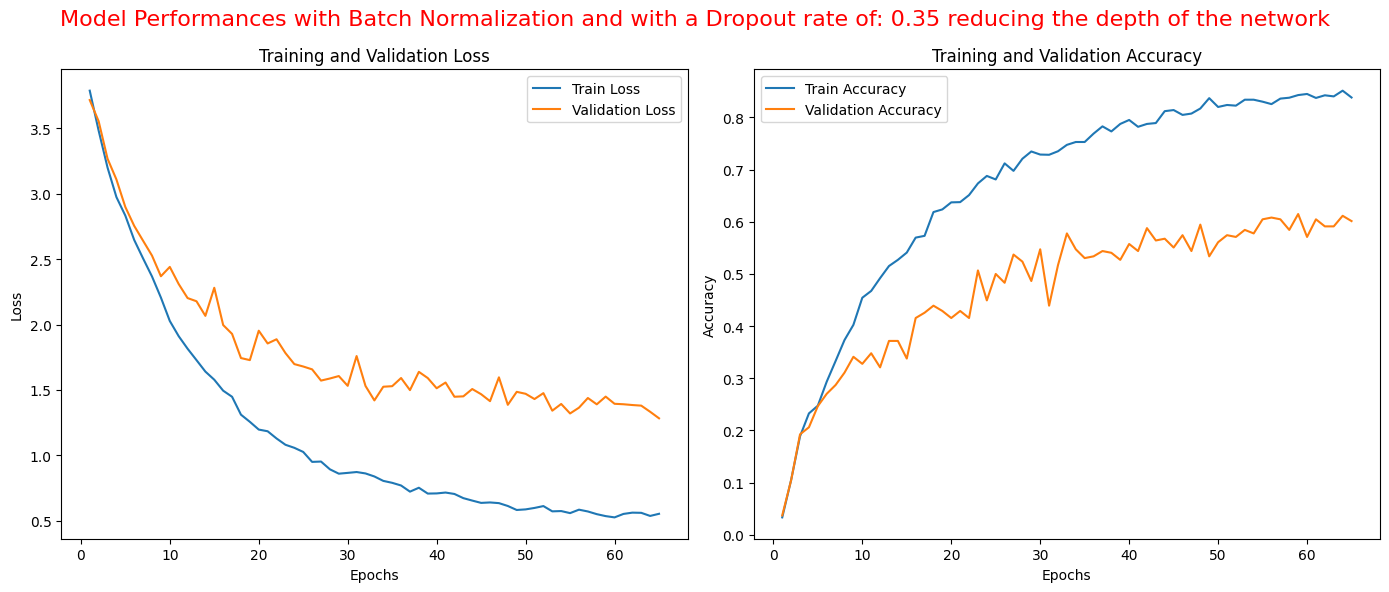

In [ ]:
title = f"Model Performances with Batch Normalization and with a Dropout rate of: {cfg['drop_out_rate']} reducing the depth of the network"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_bn_do, test_loader, device)

Accuracy of the network on the test images: 68.37%


As we can see above, a simpler model is still able to solve the task but the performances are worse. So, we prefer to mantain deeper blocks because in this way we are able to achieve higher accuracies.

### Performances with Batch Normalization and with Dropout with different transformer

In the following section we would like to use a different transformer on our dataset. In particular, we want to put away the cropping and all the other trasformations we made before.

The purpose is to understand if those transformations are useful in this situation instead of being counterproductive.

In order to don't have an out of memory error, we need to reduce the batch size of our dataset, this because having no more cropping our images present an overall higher resolution.

In [ ]:
cfg['batch_size'] = 200

In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    #T.RandomResizedCrop(cfg['crop_size']),
    #T.RandomHorizontalFlip(),
    #T.RandomVerticalFlip(),
    #T.RandomRotation(cfg['degrees'])
])

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 13
Number of batches in the val set: 1
Number of batches in the test set: 12


In [ ]:
cfg['num_epochs'] = 65

In [ ]:
model_bn_do = Model(num_classes = num_classes, use_batch_norm = True, use_dropout = True, dropout_prob = cfg['drop_out_rate'])

for name, params in model_bn_do.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
bn3.weight torch.Size([128])
bn3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
bn5.weight torch.Size([256])
bn5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
bn6.weight torch.Size([512])
bn6.bias torch.Size([512])
conv7.weight torch.Size([512, 512, 3, 3])
conv7.bias torch.Size([512])
bn7.weight torch.Size([512])
bn7.bias torch.Size([512])
conv8.weight torch.Size([43, 512, 1, 1])
conv8.bias torch.Size([43])


In [ ]:
torch.cuda.empty_cache()
model_bn_do.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
summary(model_bn_do, input_size=(3, cfg['resize_size'], cfg['resize_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 173, 173]           9,472
       BatchNorm2d-2         [-1, 64, 173, 173]             128
         MaxPool2d-3           [-1, 64, 87, 87]               0
            Conv2d-4          [-1, 128, 87, 87]          73,856
       BatchNorm2d-5          [-1, 128, 87, 87]             256
            Conv2d-6          [-1, 128, 87, 87]         147,584
       BatchNorm2d-7          [-1, 128, 87, 87]             256
         MaxPool2d-8          [-1, 128, 44, 44]               0
            Conv2d-9          [-1, 256, 44, 44]         295,168
      BatchNorm2d-10          [-1, 256, 44, 44]             512
           Conv2d-11          [-1, 256, 44, 44]         590,080
        Dropout2d-12          [-1, 256, 44, 44]               0
      BatchNorm2d-13          [-1, 256, 44, 44]             512
        MaxPool2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.AdamW(model_bn_do.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_bn_do, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 0: train loss 3.601 - train acc 10.50% - valid loss 3.742 - valid acc 10.00%
Epoch 1: train loss 3.166 - train acc 21.88% - valid loss 3.456 - valid acc 15.00%
Epoch 2: train loss 2.861 - train acc 29.46% - valid loss 2.934 - valid acc 31.50%
Epoch 3: train loss 2.547 - train acc 37.85% - valid loss 2.569 - valid acc 36.50%
Epoch 4: train loss 2.259 - train acc 43.77% - valid loss 2.479 - valid acc 33.50%
Epoch 5: train loss 1.987 - train acc 50.73% - valid loss 1.976 - valid acc 42.00%
Epoch 6: train loss 1.750 - train acc 55.38% - valid loss 2.300 - valid acc 40.00%
Epoch 7: train loss 1.644 - train acc 56.15% - valid loss 1.873 - valid acc 51.50%
Epoch 8: train loss 1.413 - train acc 64.00% - valid loss 2.072 - valid acc 46.00%
Epoch 9: train loss 1.274 - train acc 67.65% - valid loss 1.636 - valid acc 51.00%
Epoch 10: train loss 1.106 - train acc 71.27% - valid loss 1.901 - valid acc 46.00%
Epoch 11: train loss 1.040 - train acc 71.46% - valid loss 1.586 - valid acc 56.50%
Ep

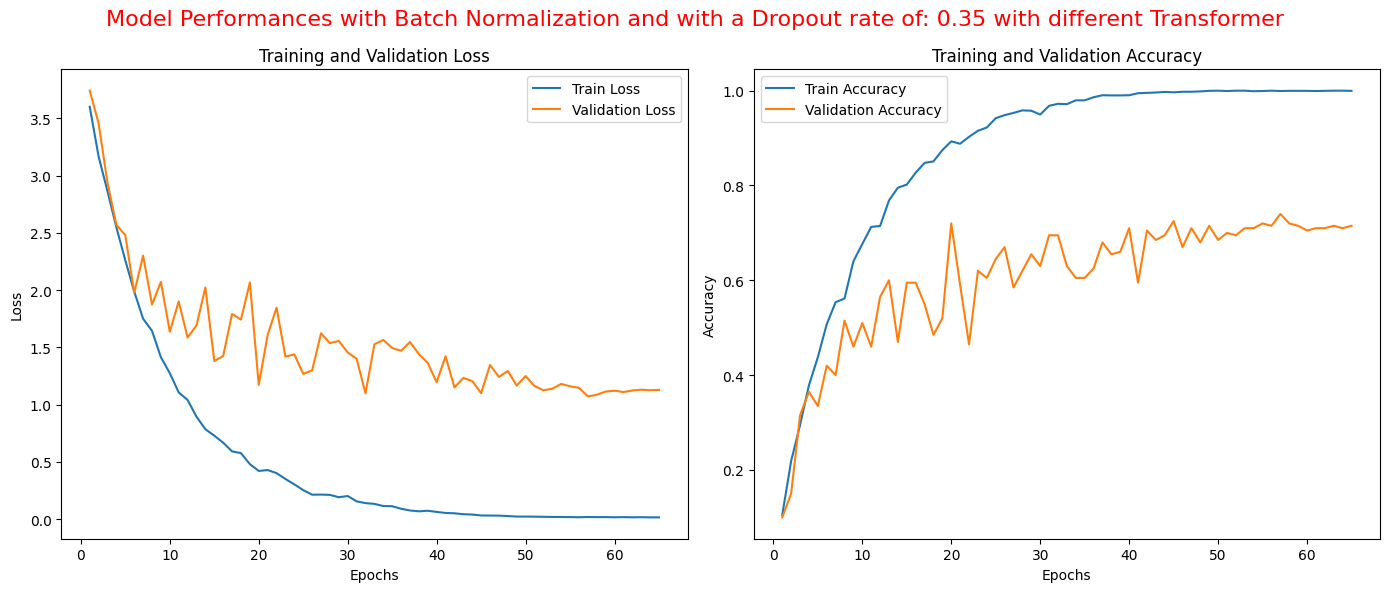

In [ ]:
title = f"Model Performances with Batch Normalization and with a Dropout rate of: {cfg['drop_out_rate']} with different Transformer"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_bn_do, test_loader, device)

Accuracy of the network on the test images: 78.58%


As we can see we were able to achieve better results compared to the previous ones.
We believe that probably the cropping in some cases makes the images no more coherent with the labels.

Note also that, putting away all the regularization, our model presents a different model capacity.

### Performances with Batch Normalization and with Dropout with different transformer without Crop

Now we would like to go deeper in our study about cropping. In this section we decided to mantain all the warping techniques (i.e. rotation and flips), but putting away the cropping.

In fact, due to the cropping it could be possible that some images could be no more coherent with the labels.

In [ ]:
cfg['batch_size'] = 200

In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    #T.RandomResizedCrop(cfg['crop_size']),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(cfg['degrees'])
])

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

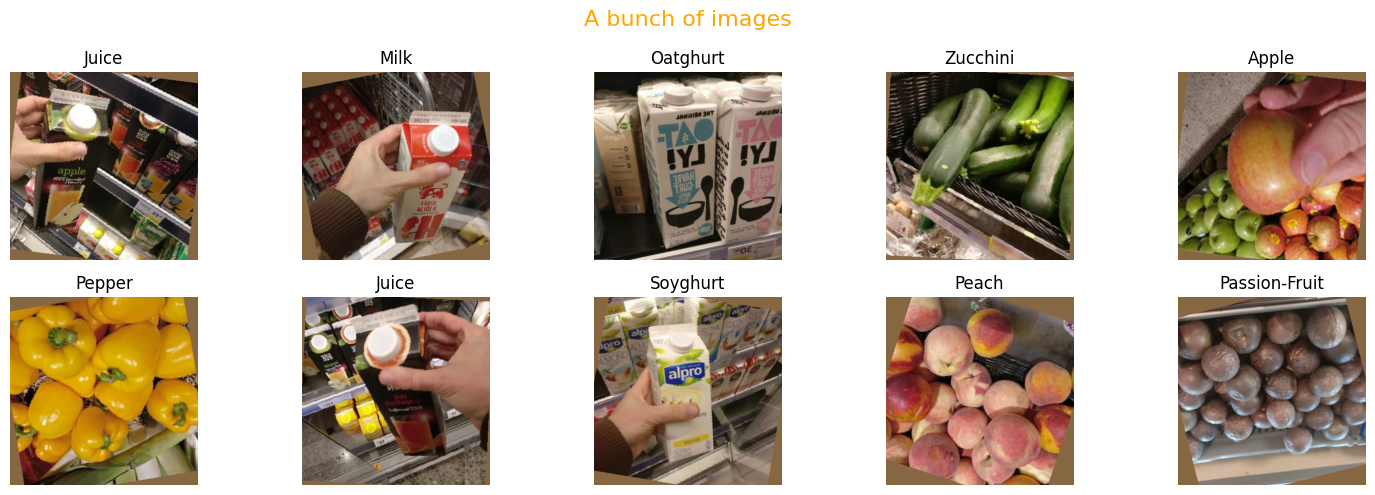

In [ ]:
denormalize = NormalizeInverse(mean_image_net, std_image_net)
show_grid(val, dict_num_classes, process=denormalize)

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 13
Number of batches in the val set: 1
Number of batches in the test set: 12


In [ ]:
cfg['num_epochs'] = 60

In [ ]:
model_bn_do = Model(num_classes = num_classes, use_batch_norm = True, use_dropout = True, dropout_prob = cfg['drop_out_rate'])

for name, params in model_bn_do.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
bn3.weight torch.Size([128])
bn3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
bn5.weight torch.Size([256])
bn5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
bn6.weight torch.Size([512])
bn6.bias torch.Size([512])
conv7.weight torch.Size([512, 512, 3, 3])
conv7.bias torch.Size([512])
bn7.weight torch.Size([512])
bn7.bias torch.Size([512])
conv8.weight torch.Size([43, 512, 1, 1])
conv8.bias torch.Size([43])


In [ ]:
torch.cuda.empty_cache()
model_bn_do.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
summary(model_bn_do, input_size=(3, cfg['resize_size'], cfg['resize_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 173, 173]           9,472
       BatchNorm2d-2         [-1, 64, 173, 173]             128
         MaxPool2d-3           [-1, 64, 87, 87]               0
            Conv2d-4          [-1, 128, 87, 87]          73,856
       BatchNorm2d-5          [-1, 128, 87, 87]             256
            Conv2d-6          [-1, 128, 87, 87]         147,584
       BatchNorm2d-7          [-1, 128, 87, 87]             256
         MaxPool2d-8          [-1, 128, 44, 44]               0
            Conv2d-9          [-1, 256, 44, 44]         295,168
      BatchNorm2d-10          [-1, 256, 44, 44]             512
           Conv2d-11          [-1, 256, 44, 44]         590,080
        Dropout2d-12          [-1, 256, 44, 44]               0
      BatchNorm2d-13          [-1, 256, 44, 44]             512
        MaxPool2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.AdamW(model_bn_do.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_bn_do, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 0: train loss 3.504 - train acc 12.15% - valid loss 3.730 - valid acc 10.00%
Epoch 1: train loss 3.039 - train acc 25.77% - valid loss 3.413 - valid acc 14.00%
Epoch 2: train loss 2.727 - train acc 33.50% - valid loss 3.020 - valid acc 21.00%
Epoch 3: train loss 2.437 - train acc 39.00% - valid loss 2.574 - valid acc 35.00%
Epoch 4: train loss 2.200 - train acc 44.12% - valid loss 2.443 - valid acc 33.50%
Epoch 5: train loss 1.993 - train acc 48.08% - valid loss 1.913 - valid acc 48.00%
Epoch 6: train loss 1.811 - train acc 52.35% - valid loss 1.910 - valid acc 47.00%
Epoch 7: train loss 1.628 - train acc 56.77% - valid loss 2.038 - valid acc 47.00%
Epoch 8: train loss 1.470 - train acc 61.46% - valid loss 1.799 - valid acc 42.50%
Epoch 9: train loss 1.349 - train acc 64.04% - valid loss 1.908 - valid acc 42.50%
Epoch 10: train loss 1.225 - train acc 66.35% - valid loss 2.491 - valid acc 39.00%
Epoch 11: train loss 1.186 - train acc 67.46% - valid loss 1.735 - valid acc 49.50%
Ep

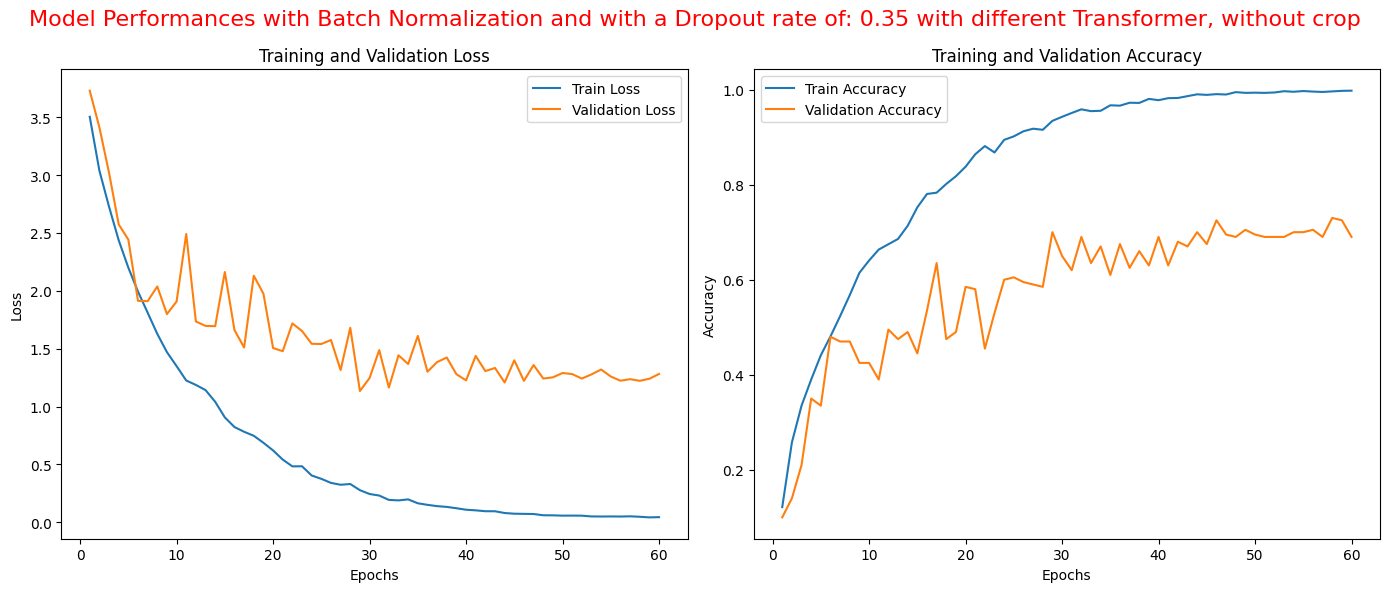

In [ ]:
title = f"Model Performances with Batch Normalization and with a Dropout rate of: {cfg['drop_out_rate']} with different Transformer, without crop"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_bn_do, test_loader, device)

Accuracy of the network on the test images: 77.21%


From the results obtained above we can see that we are able to achive better accuracies without any rotation, flip or cropping.

However, in all cases the proposed model is able to achieve the required accuracy or values greater than 60%.

It is also probable that we are able to achieve higher accuracies just because of the model capacity. Maybe training the original model, with cropping and warping procedures, but for a bigger amount of epochs, we should be able to achieve higher accuracies. But this is not the purpose of this task.

### Performances with BatchNorm and Dropout, bringing it until 130 epochs

In this section we would like to train our model using the first transformer but for more epochs. In fact, the idea is to try to rise the accuracy as much as possible in order to be able to make a fair comparison between all the transformers we used.

In [ ]:
cfg['num_epochs'] = 130

Obviously, we are going to use both batch normalization and dropout.

In [ ]:
model_bn_do = Model(num_classes = num_classes, use_batch_norm = True, use_dropout = True, dropout_prob = cfg['drop_out_rate'])

for name, params in model_bn_do.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
conv1.bias torch.Size([64])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
bn3.weight torch.Size([128])
bn3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
bn5.weight torch.Size([256])
bn5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
bn6.weight torch.Size([512])
bn6.bias torch.Size([512])
conv7.weight torch.Size([512, 512, 3, 3])
conv7.bias torch.Size([512])
bn7.weight torch.Size([512])
bn7.bias torch.Size([512])
conv8.weight torch.Size([43, 512, 1, 1])
conv8.bias torch.Size([43])


In [ ]:
torch.cuda.empty_cache()
model_bn_do.to(device)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
summary(model_bn_do, input_size=(3, cfg['crop_size'], cfg['crop_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]          73,856
       BatchNorm2d-5          [-1, 128, 56, 56]             256
            Conv2d-6          [-1, 128, 56, 56]         147,584
       BatchNorm2d-7          [-1, 128, 56, 56]             256
         MaxPool2d-8          [-1, 128, 28, 28]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 256, 28, 28]         590,080
        Dropout2d-12          [-1, 256, 28, 28]               0
      BatchNorm2d-13          [-1, 256, 28, 28]             512
        MaxPool2d-14          [-1, 256,

In [ ]:
optimizer = torch.optim.AdamW(model_bn_do.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_bn_do, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch 0: train loss 3.578 - train acc 11.02% - valid loss 3.756 - valid acc 4.39%
Epoch 1: train loss 3.227 - train acc 21.71% - valid loss 3.708 - valid acc 6.76%
Epoch 2: train loss 2.992 - train acc 25.89% - valid loss 3.473 - valid acc 12.16%
Epoch 3: train loss 2.801 - train acc 29.69% - valid loss 3.190 - valid acc 16.22%
Epoch 4: train loss 2.656 - train acc 32.56% - valid loss 2.944 - valid acc 19.26%
Epoch 5: train loss 2.516 - train acc 35.39% - valid loss 2.778 - valid acc 28.38%
Epoch 6: train loss 2.346 - train acc 38.05% - valid loss 2.778 - valid acc 25.68%
Epoch 7: train loss 2.233 - train acc 42.06% - valid loss 2.595 - valid acc 30.74%
Epoch 8: train loss 2.103 - train acc 44.34% - valid loss 2.405 - valid acc 32.09%
Epoch 9: train loss 1.951 - train acc 46.83% - valid loss 2.256 - valid acc 39.19%
Epoch 10: train loss 1.807 - train acc 51.86% - valid loss 2.237 - valid acc 41.22%
Epoch 11: train loss 1.756 - train acc 52.58% - valid loss 2.178 - valid acc 36.15%
Epoc

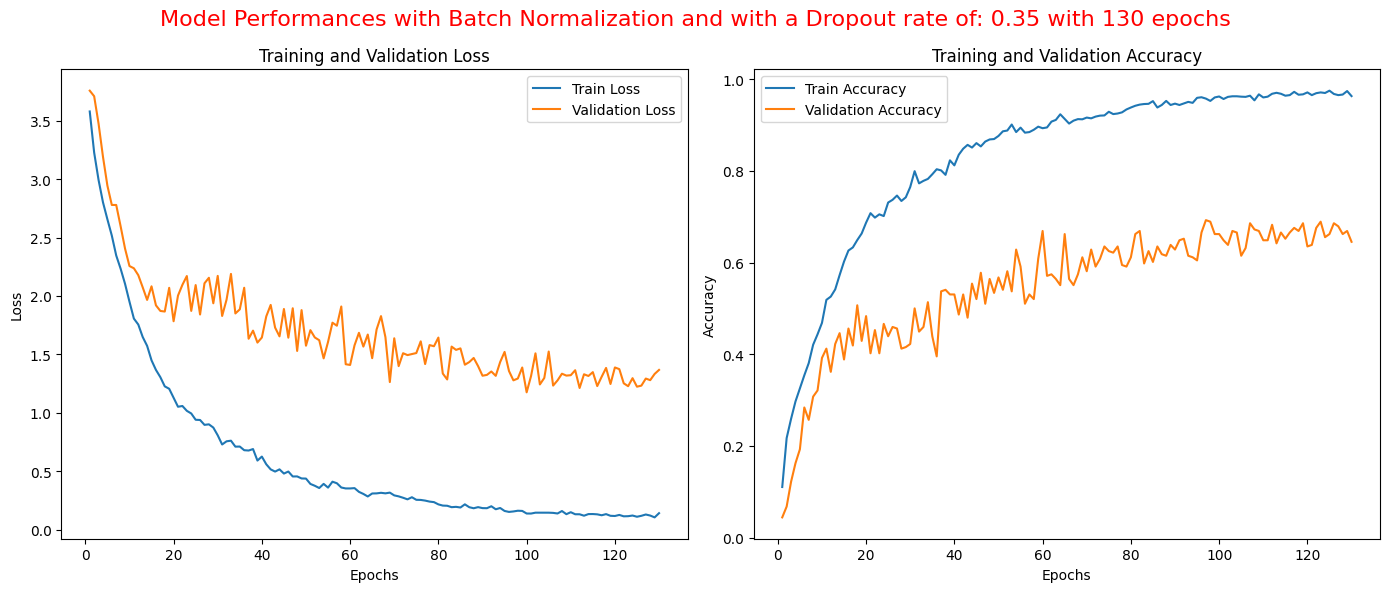

In [ ]:
title = f"Model Performances with Batch Normalization and with a Dropout rate of: {cfg['drop_out_rate']} with {cfg['num_epochs']} epochs"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_bn_do, test_loader, device)

Accuracy of the network on the test images: 74.49%


Despite the  great amount of epoch we were not able to bring our model to have a train accuracy near the 100, as we have done before using the others transformers. It's clear that this is caused by regularization.

By the way, again, the results are pretty good, in fact we reached an accuracy over the 60%, which was the required amount.

### Final Conclusions for Task 1

To solve this task, we wanted to try using an unusual architecture that did not include FC layers at the end. The basic idea was to create a model that used very few parameters and could solve the task. We decided to create a model made up of standard blocks, following the examples of ResNet and Inception. Each block consists of a pair of convolutional layers followed by batch normalization, and after the pair, a max pooling operation is always performed. These blocks make up the feature extractor, while the classifier consists of a single layer that performs Average Pooling. Finally, a 1x1 convolutional layer serves as the interface between the feature extractor and the classifier.

In all our training trials, we decided to use the AdamW optimizer and relied on a One Cycle Scheduler.

During the study of the proposed model, we decided to test the effectiveness of each of its components. First, we wanted to test the model without using either batch normalization or dropout. The results obtained were not acceptable for solving the task, as the accuracy hovered around 50%, never reaching the required 60%. We then continued the study by testing the model with batch normalization and without dropout. This allowed us to demonstrate the extreme effectiveness of batch normalization as a regularization technique. In this way, we managed to achieve an accuracy that exceeded 60%. Once we established that batch normalization was necessary to obtain the required accuracy values, we wondered if dropout could further improve the results. An important mention must be made regarding the type of dropout used in our network: since the model does not have FC layers, it is not possible to apply any dropout on them. Consequently, we looked for some technique to perform dropout on convolutional layers. This is possible by "turning off" feature maps. To do this, we decided to implement a 2-Dimensional dropout. We then tested the model performing both batch normalization and dropout as regularization techniques. The results were not much different from the previous trial. This leads us to think that, in the case presented here, dropout is not as effective a technique as we expected.

Now, the presented model, as already mentioned, has a convolutional layer that performs a 1x1 convolution. This layer serves as the interface between the feature extractor and the classifier. In fact, to use an Average Pooling layer as a classifier, it is necessary for it to have an input number of channels equal to the number of classes (43 in our case). Therefore, the convolutional layer can drastically reduce the channels and provide the classifier with a number equal to the number of classes. But why use a 1x1 convolution? During the design of our network, we noticed that it was also possible to interface the classifier directly with the feature extractor. However, in tests, we found that removing that 1x1 convolutional layer and using an additional block instead could lead to better results but at the cost of using about double the parameters and much longer training times. Thus, we concluded that:

adding more layers was not necessary for the task (since the model was already able to reach the required accuracy values using many fewer parameters);
a 1x1 convolutional layer was capable of interfacing the classifier and the feature extractor using few parameters.
Next, we wanted to test the blocks that make up the feature extractor of our model. In particular, we decided to "halve their complexity" by removing one convolution and one batch normalization. The results obtained were still satisfactory; in fact, the model was able to achieve the required accuracy (about 60%) with less than half the parameters (1.5M). However, the results were worse than the previous case. So, reducing the model's complexity is possible, but only within the limits shown in this notebook, as removing additional layers means the network can no longer reach the required accuracy levels.

At this point, we wanted to test the transformer we originally used. In fact, the first transformer applies a series of transformations to the input images: rotation, cropping, and flipping (both vertical and horizontal). We then removed these transformations. What we obtained, of course, was that the model was able to train much faster. This is because by removing the regularization systems, the model's capacity varied significantly. To our great surprise, however, the model exhibited better accuracy compared to previous tests. In light of this test, we thought the reasons could be as follows:


*   the model, with 4M parameters, has the necessary complexity to solve the task, even without implementing transformations on the input;
*   transformations, especially cropping, could lead to a mismatch between the labels and the cropped images.


Due to the results obtained from the previous test, we decided to try eliminating only the cropping from our transformer. What we obtained were essentially the same results as when removing all transformations. This suggested to us that cropping likely causes the model to "get confused." In fact, random or central cropping is not necessarily a useful idea for this dataset. This is because in many images, cropping causes a deep mismatch between the label and the image.

Since removing transformations from the input significantly changed the model's capacity, we decided to perform one last test. We wanted to try training the model for a very large number of epochs with the initial transformer. The results obtained are comparable to those obtained previously. This indicates that in our case, cropping indeed causes problems for the model during training, likely because labels and images, in some cases, are no longer consistent.

In conclusion:

*   the use of an Average Pooling Classifier proved to be an effective technique
for solving the task;
*   Batch Normalization was a necessary technique to significantly increase the model's accuracy;
*   the application or not of dropout did not lead to significant differences in results, although we decided to keep it for the rest of the tests;
*   the 1x1 convolutional layer proved to be very useful for interfacing the classifier with the feature extractor while keeping the number of trainable parameters to a minimum;
*   adding even just one more block made the model excessively complex for solving the task;
*   by reducing the model's complexity, we still managed to solve the task, but at the cost of significantly lowering the accuracy compared to before;
*   conducting tests with different transformers showed how cropping causes training problems for the model, likely due to mismatches between labels and images.

## Solution Part 2

### ResNet-18 with cropping

In this section we would like to perform a training process on ResNet-18 with the hyperparameters used in the first task.

Note, in particular, that we cannot perform a dropout like we have done with our model because ResNet-18 doesn't permit to us to do so:


*   [pytorch ResNet-18 doc;](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
*   [pytorch ResNet-18 implementation.](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)

Thus, we will not use any dropout.

In [ ]:
from torchvision import models

# Load the pretrained ResNet-18 model
model_resnet = models.resnet18(weights='IMAGENET1K_V1')

# the final fully connected layer to match the number of classes in GroceryStoreDataset
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)  # num_classes is the number of classes in your dataset

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


We are going to use the highest number of epochs we used in the first task: 130.

In [ ]:
cfg['num_epochs'] = 130

In [ ]:
for name, params in model_resnet.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [ ]:
torch.cuda.empty_cache()
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_resnet, input_size=(3, cfg['crop_size'], cfg['crop_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

As we have done in the first task we are going to use as optimizer AdamW, while as scheduler we use OneCycle.

Obviously, we are going to use the same values for the learning rate and the weight decay.

In [ ]:
optimizer = torch.optim.AdamW(model_resnet.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_resnet, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch 0: train loss 3.748 - train acc 7.73% - valid loss 3.456 - valid acc 14.53%
Epoch 1: train loss 3.035 - train acc 26.22% - valid loss 2.858 - valid acc 29.39%
Epoch 2: train loss 2.421 - train acc 43.12% - valid loss 2.442 - valid acc 38.51%
Epoch 3: train loss 1.952 - train acc 54.35% - valid loss 2.089 - valid acc 48.99%
Epoch 4: train loss 1.602 - train acc 62.08% - valid loss 1.815 - valid acc 51.69%
Epoch 5: train loss 1.237 - train acc 69.72% - valid loss 1.521 - valid acc 58.78%
Epoch 6: train loss 0.976 - train acc 78.21% - valid loss 1.254 - valid acc 66.22%
Epoch 7: train loss 0.750 - train acc 84.33% - valid loss 1.061 - valid acc 70.95%
Epoch 8: train loss 0.585 - train acc 87.08% - valid loss 0.924 - valid acc 73.65%
Epoch 9: train loss 0.434 - train acc 91.55% - valid loss 0.803 - valid acc 76.35%
Epoch 10: train loss 0.320 - train acc 93.88% - valid loss 0.697 - valid acc 81.08%
Epoch 11: train loss 0.255 - train acc 94.76% - valid loss 0.631 - valid acc 80.41%
Epo

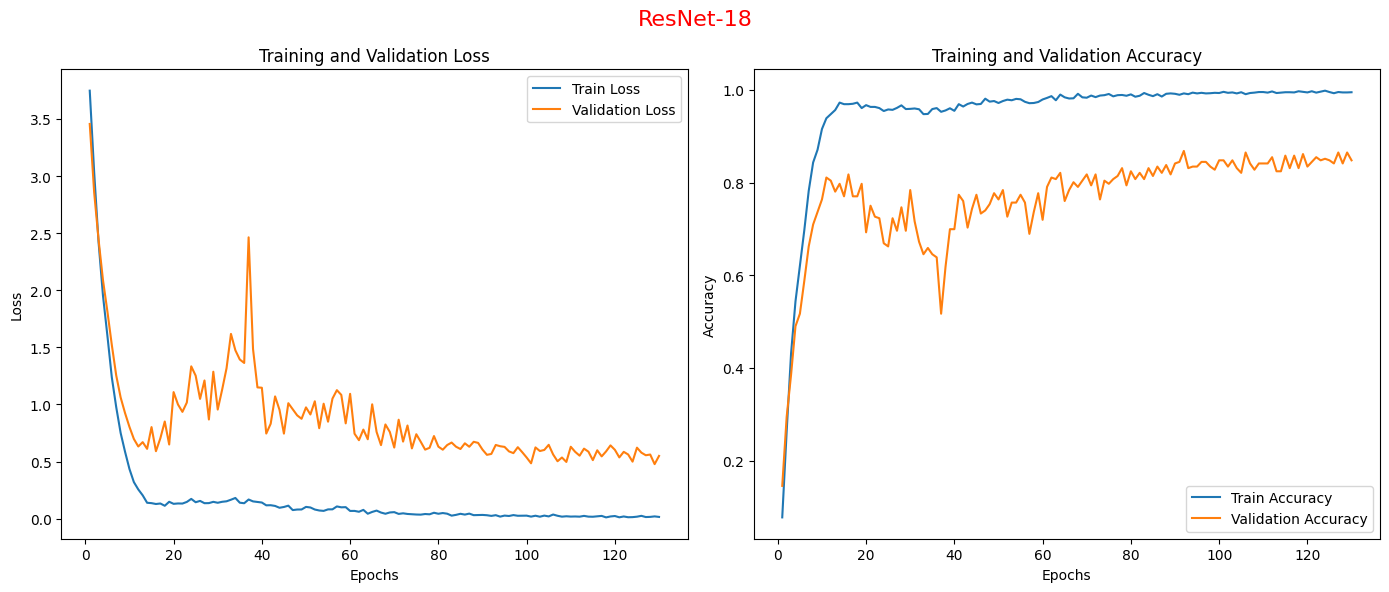

In [ ]:
title = f"ResNet-18"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_resnet, test_loader, device)

Accuracy of the network on the test images: 87.54%


From the results above we can see that we are able to successfuly reach the required accuracy. Thus, what we can do now is to try to change our hyperparameters in order to reach better accuracies, if possible.

### ResNet-18 without cropping

In the first task we have seen that putting away the cropping on our dataset improved the model's performances. So, the idea is to try to do the same thing with ResNet-18.

In this section we are going to mantain some transformations (flips and rotation) but we don't perform the cropping.

In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    #T.RandomResizedCrop(cfg['crop_size']),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(cfg['degrees'])
])

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

As we had to do in task 1 we need to reduce the batch size in order to load the model. Thus, we want to use the same batch size used before so as to make a fair comparison between ResNet-18 and our model.

In [ ]:
cfg['batch_size'] = 200

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 13
Number of batches in the val set: 1
Number of batches in the test set: 12


In [ ]:
from torchvision import models

# Load the pretrained ResNet-18 model
model_resnet_no_crop = models.resnet18(weights='IMAGENET1K_V1')

# the final fully connected layer to match the number of classes in GroceryStoreDataset
num_ftrs = model_resnet_no_crop.fc.in_features
model_resnet_no_crop.fc = nn.Linear(num_ftrs, num_classes)  # num_classes is the number of classes in your dataset

In [ ]:
cfg['num_epochs'] = 130

In [ ]:
for name, params in model_resnet_no_crop.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [ ]:
torch.cuda.empty_cache()
model_resnet_no_crop.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_resnet_no_crop, input_size=(3, cfg['resize_size'], cfg['resize_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 173, 173]           9,408
       BatchNorm2d-2         [-1, 64, 173, 173]             128
              ReLU-3         [-1, 64, 173, 173]               0
         MaxPool2d-4           [-1, 64, 87, 87]               0
            Conv2d-5           [-1, 64, 87, 87]          36,864
       BatchNorm2d-6           [-1, 64, 87, 87]             128
              ReLU-7           [-1, 64, 87, 87]               0
            Conv2d-8           [-1, 64, 87, 87]          36,864
       BatchNorm2d-9           [-1, 64, 87, 87]             128
             ReLU-10           [-1, 64, 87, 87]               0
       BasicBlock-11           [-1, 64, 87, 87]               0
           Conv2d-12           [-1, 64, 87, 87]          36,864
      BatchNorm2d-13           [-1, 64, 87, 87]             128
             ReLU-14           [-1, 64,

In [ ]:
optimizer = torch.optim.AdamW(model_resnet_no_crop.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop(model_resnet_no_crop, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch 0: train loss 3.431 - train acc 15.27% - valid loss 2.801 - valid acc 37.00%
Epoch 1: train loss 2.371 - train acc 43.50% - valid loss 2.121 - valid acc 47.00%
Epoch 2: train loss 1.713 - train acc 58.35% - valid loss 1.753 - valid acc 56.00%
Epoch 3: train loss 1.250 - train acc 70.38% - valid loss 1.447 - valid acc 58.50%
Epoch 4: train loss 0.889 - train acc 82.35% - valid loss 1.144 - valid acc 67.50%
Epoch 5: train loss 0.602 - train acc 88.92% - valid loss 1.001 - valid acc 69.00%
Epoch 6: train loss 0.390 - train acc 93.62% - valid loss 0.865 - valid acc 70.50%
Epoch 7: train loss 0.246 - train acc 97.54% - valid loss 0.745 - valid acc 77.00%
Epoch 8: train loss 0.149 - train acc 98.88% - valid loss 0.616 - valid acc 83.00%
Epoch 9: train loss 0.093 - train acc 99.42% - valid loss 0.581 - valid acc 81.00%
Epoch 10: train loss 0.058 - train acc 99.62% - valid loss 0.517 - valid acc 84.00%
Epoch 11: train loss 0.037 - train acc 99.81% - valid loss 0.458 - valid acc 87.00%
Ep

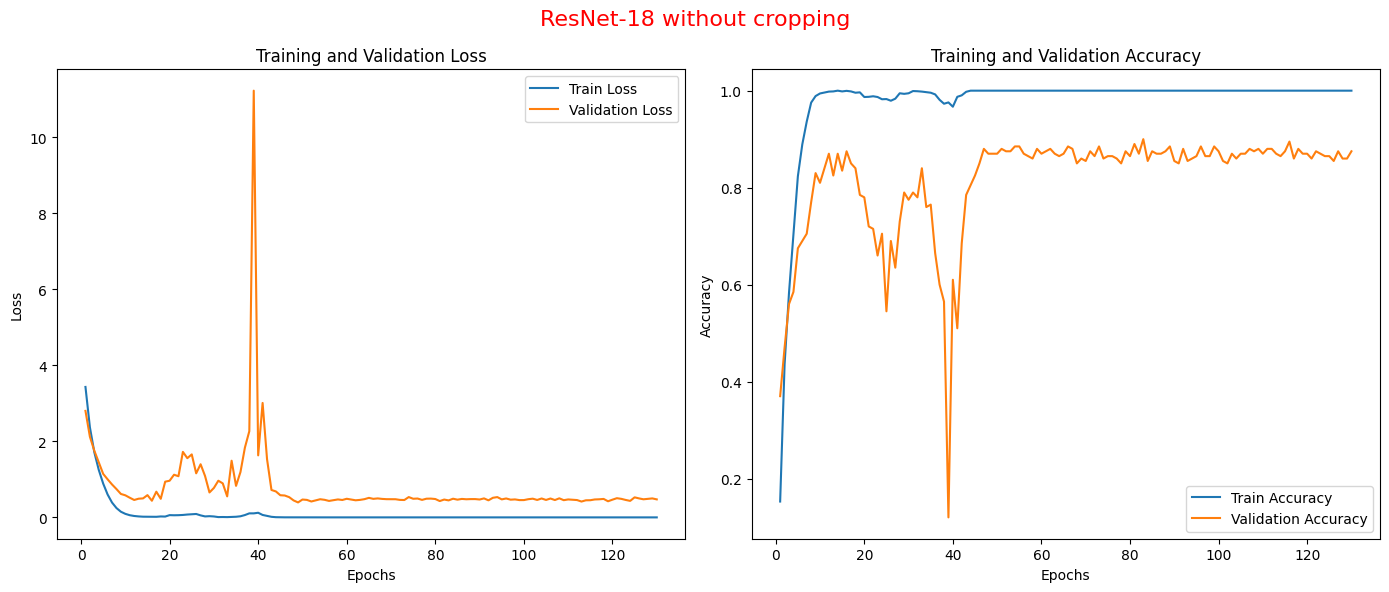

In [ ]:
title = f"ResNet-18 without cropping"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_resnet_no_crop, test_loader, device)

Accuracy of the network on the test images: 89.17%


As we can see erasing the cropping we are able to achieve better results, as in task 1. Thus, for the next attempts we are going to not use the cropping.

### ResNet-18: label smoothing, no cropping

In this section we would like to try to apply a label smoothing in our cross entropy loss function in order to achieve better performances.

We know that this is a good practise and we also saw that this as been done during the ResNet training: [ResNet pytorch hyperparameters](https://github.com/pytorch/vision/tree/main/references/classification#resnet).

Also, we have seen that the usage of label smoothing improved the accuracies on ResNet: [training recipes for ResNet](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/). We will use the same value used in the last link: 0.1.

The idea is to use the same scheduler and the same optimizer used before. The only thing we want to change is the fact that we are going to implement a label smoothing.

Thus, we need to define our trainer again.

In [ ]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop_ls(model, train_loader, epochs, opt, scheduler, val_loader=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_loader:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels, label_smoothing=0.1)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use
            scheduler.step()

        train_acc /= train_samples
        train_loss /= train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():   # No need to calculate gradients
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_loader is not None:
                for val_data in val_loader:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

            if val_loader is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_loader is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {(100*train_acc):.2f}%" +
                  ("" if val_loader is None else f" - valid loss {val_loss:.3f} - valid acc {(100*val_acc):.2f}%"))

    if verbose and val_loader is not None:
        print(f"\nBest epoch: {best_epoch}, best acc: {(100*best_val_acc):.2f}%")

    # Return metrics for plotting
    return best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    #T.RandomResizedCrop(cfg['crop_size']),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(cfg['degrees'])
])

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

In [ ]:
cfg['batch_size'] = 220

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 12
Number of batches in the val set: 1
Number of batches in the test set: 11


In [ ]:
from torchvision import models

# Load the pretrained ResNet-18 model
model_resnet_no_crop = models.resnet18(weights='IMAGENET1K_V1')

# the final fully connected layer to match the number of classes in GroceryStoreDataset
num_ftrs = model_resnet_no_crop.fc.in_features
model_resnet_no_crop.fc = nn.Linear(num_ftrs, num_classes)  # num_classes is the number of classes in your dataset

In [ ]:
cfg['num_epochs'] = 90

In [ ]:
for name, params in model_resnet_no_crop.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [ ]:
torch.cuda.empty_cache()
model_resnet_no_crop.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_resnet_no_crop, input_size=(3, cfg['resize_size'], cfg['resize_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 173, 173]           9,408
       BatchNorm2d-2         [-1, 64, 173, 173]             128
              ReLU-3         [-1, 64, 173, 173]               0
         MaxPool2d-4           [-1, 64, 87, 87]               0
            Conv2d-5           [-1, 64, 87, 87]          36,864
       BatchNorm2d-6           [-1, 64, 87, 87]             128
              ReLU-7           [-1, 64, 87, 87]               0
            Conv2d-8           [-1, 64, 87, 87]          36,864
       BatchNorm2d-9           [-1, 64, 87, 87]             128
             ReLU-10           [-1, 64, 87, 87]               0
       BasicBlock-11           [-1, 64, 87, 87]               0
           Conv2d-12           [-1, 64, 87, 87]          36,864
      BatchNorm2d-13           [-1, 64, 87, 87]             128
             ReLU-14           [-1, 64,

In [ ]:
optimizer = torch.optim.AdamW(model_resnet_no_crop.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop_ls(model_resnet_no_crop, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch 0: train loss 3.379 - train acc 21.36% - valid loss 2.787 - valid acc 37.73%
Epoch 1: train loss 2.491 - train acc 49.89% - valid loss 2.086 - valid acc 48.64%
Epoch 2: train loss 1.943 - train acc 63.26% - valid loss 1.644 - valid acc 57.27%
Epoch 3: train loss 1.541 - train acc 75.76% - valid loss 1.330 - valid acc 60.91%
Epoch 4: train loss 1.238 - train acc 85.38% - valid loss 1.126 - valid acc 64.55%
Epoch 5: train loss 1.022 - train acc 94.13% - valid loss 0.969 - valid acc 71.36%
Epoch 6: train loss 0.893 - train acc 97.01% - valid loss 0.874 - valid acc 81.36%
Epoch 7: train loss 0.819 - train acc 99.09% - valid loss 0.839 - valid acc 82.73%
Epoch 8: train loss 0.779 - train acc 99.43% - valid loss 0.819 - valid acc 84.09%
Epoch 9: train loss 0.754 - train acc 99.81% - valid loss 0.776 - valid acc 84.09%
Epoch 10: train loss 0.744 - train acc 99.89% - valid loss 0.778 - valid acc 85.91%
Epoch 11: train loss 0.735 - train acc 99.77% - valid loss 0.823 - valid acc 86.82%
Ep

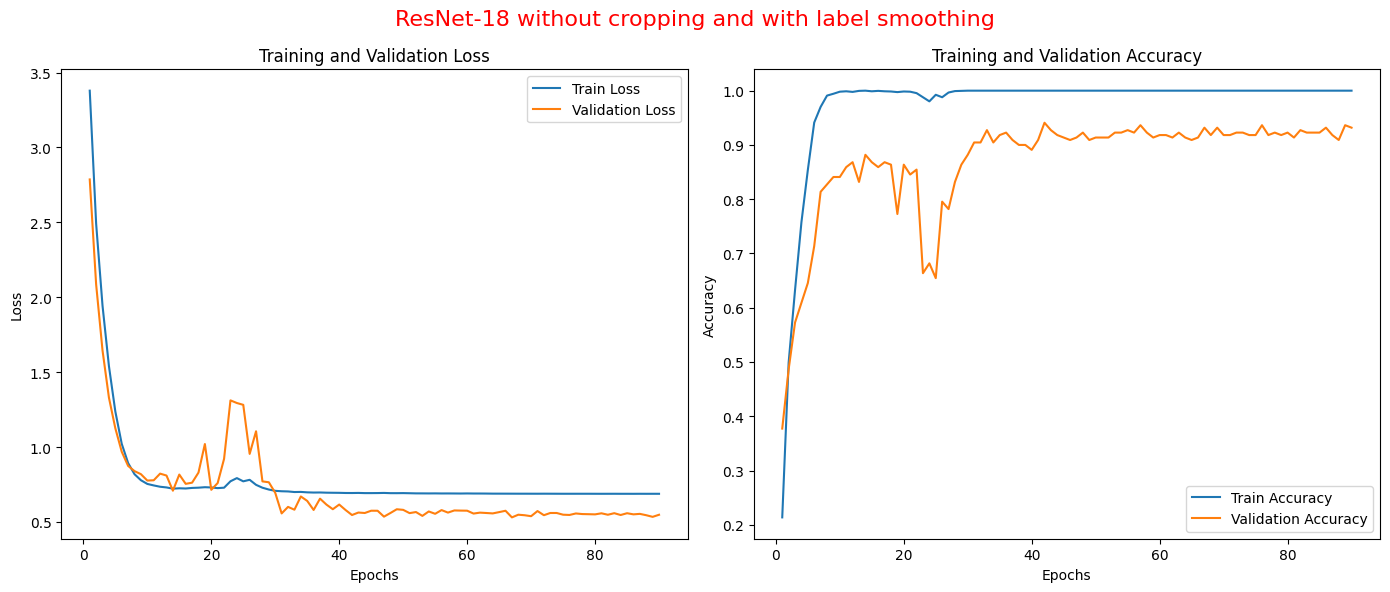

In [ ]:
title = f"ResNet-18 without cropping and with label smoothing"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_resnet_no_crop, test_loader, device)

Accuracy of the network on the test images: 92.77%


Again, we improved the performances using label smoothing. We didn't use this technique with the model presented in task 1 because we already reached the required accuracy values.

### ResNet-18 CosineAnnealing and warm-up

In this guide: [training recipe for ResNet](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/) we have seen that the authors decided to use a Cosine Annealing scheduler after some warm-up epochs.

Thus, the purpose of this section is to try to use the same technique in order to improve the accuracies, if possible.

In particular, they used [SequentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.SequentialLR.html#torch.optim.lr_scheduler.SequentialLR) scheduler in order to initially use a [LinearLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html) and then the [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html). So, we want to do same. The only difference is that, for now, we want to use as optimizer AdamW and not SGD.

Due to the better results obtained before, applying label smoothing, we are going to use it again.

In [ ]:
cfg = {
    "resize_size": 345,
    "crop_size": 224,
    "degrees": 20,

    "batch_size": 220,
    "num_epochs": 90,

    "lr": 1e-3,
    "wd": 1e-4,
    "lr_warmup_epochs" : 5,
    "lr_warmup_decay" : 0.01,

    'drop_out_rate': 0.35
}

In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    #T.RandomResizedCrop(cfg['crop_size']),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(cfg['degrees'])
])

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 12
Number of batches in the val set: 1
Number of batches in the test set: 11


In [ ]:
from torchvision import models

# Load the pretrained ResNet-18 model
model_resnet_no_crop = models.resnet18(weights='IMAGENET1K_V1')

# the final fully connected layer to match the number of classes in GroceryStoreDataset
num_ftrs = model_resnet_no_crop.fc.in_features
model_resnet_no_crop.fc = nn.Linear(num_ftrs, num_classes)  # num_classes is the number of classes in your dataset

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [ ]:
for name, params in model_resnet_no_crop.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [ ]:
torch.cuda.empty_cache()
model_resnet_no_crop.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_resnet_no_crop, input_size=(3, cfg['resize_size'], cfg['resize_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 173, 173]           9,408
       BatchNorm2d-2         [-1, 64, 173, 173]             128
              ReLU-3         [-1, 64, 173, 173]               0
         MaxPool2d-4           [-1, 64, 87, 87]               0
            Conv2d-5           [-1, 64, 87, 87]          36,864
       BatchNorm2d-6           [-1, 64, 87, 87]             128
              ReLU-7           [-1, 64, 87, 87]               0
            Conv2d-8           [-1, 64, 87, 87]          36,864
       BatchNorm2d-9           [-1, 64, 87, 87]             128
             ReLU-10           [-1, 64, 87, 87]               0
       BasicBlock-11           [-1, 64, 87, 87]               0
           Conv2d-12           [-1, 64, 87, 87]          36,864
      BatchNorm2d-13           [-1, 64, 87, 87]             128
             ReLU-14           [-1, 64,

In [ ]:
optimizer = torch.optim.AdamW(model_resnet_no_crop.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
num_steps = cfg['num_epochs'] * len(train_loader)

# we create the linear warmup scheduler
linear_scheduler = LinearLR(optimizer, start_factor=cfg['lr_warmup_decay'], total_iters=cfg['lr_warmup_epochs'])
# after warmup we use a cosine annealing scheduler
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=cfg['num_epochs'] - cfg['lr_warmup_epochs'], eta_min=cfg['lr_warmup_decay'])

scheduler = SequentialLR(optimizer, schedulers=[linear_scheduler, cosine_scheduler], milestones=[cfg['lr_warmup_epochs']])

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop_ls(model_resnet_no_crop, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0: train loss 2.340 - train acc 48.48% - valid loss 2.737 - valid acc 46.82%
Epoch 1: train loss 1.131 - train acc 89.66% - valid loss 2.418 - valid acc 44.55%
Epoch 2: train loss 1.005 - train acc 93.71% - valid loss 3.523 - valid acc 26.36%
Epoch 3: train loss 1.135 - train acc 88.30% - valid loss 6.777 - valid acc 20.45%
Epoch 4: train loss 1.198 - train acc 85.61% - valid loss 9.098 - valid acc 3.18%
Epoch 5: train loss 1.244 - train acc 84.43% - valid loss 4.674 - valid acc 16.82%
Epoch 6: train loss 1.205 - train acc 86.14% - valid loss 6.963 - valid acc 6.82%
Epoch 7: train loss 1.059 - train acc 91.25% - valid loss 4.812 - valid acc 16.36%
Epoch 8: train loss 0.942 - train acc 95.30% - valid loss 1.843 - valid acc 53.18%
Epoch 9: train loss 0.883 - train acc 97.65% - valid loss 0.925 - valid acc 76.82%
Epoch 10: train loss 0.820 - train acc 98.64% - valid loss 1.284 - valid acc 73.64%
Epoch 11: train loss 0.777 - train acc 99.73% - valid loss 1.094 - valid acc 76.36%
Epoc

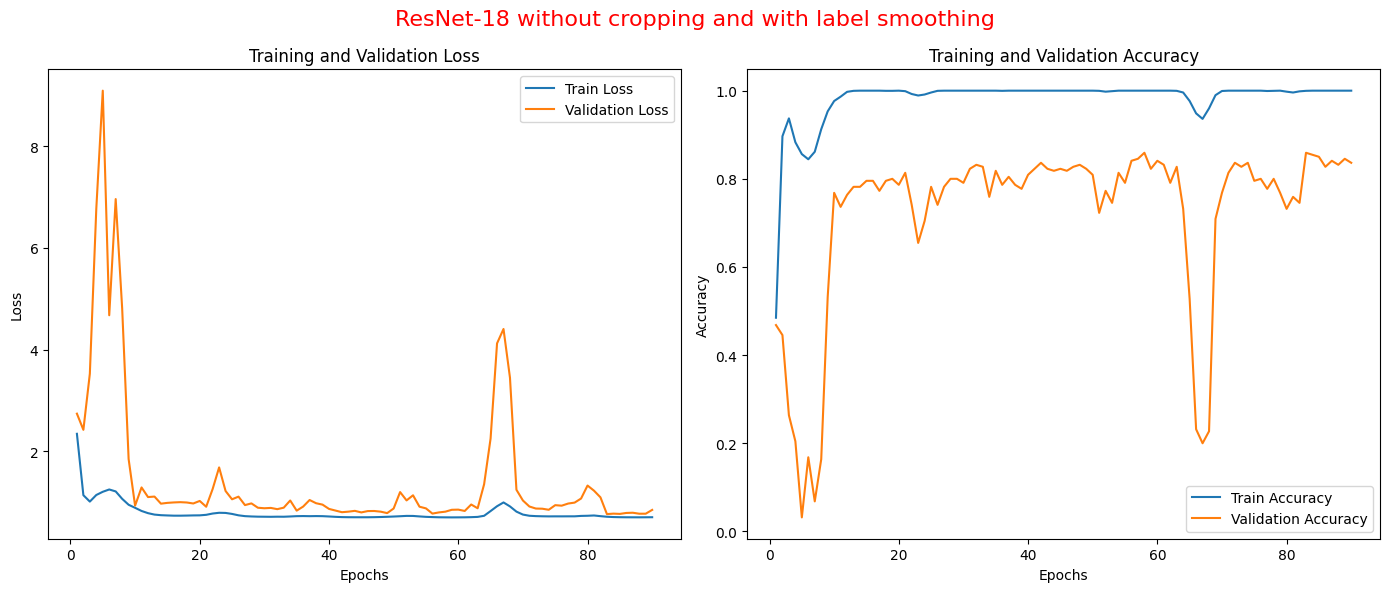

In [ ]:
title = f"ResNet-18 without cropping and with label smoothing"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_resnet_no_crop, test_loader, device)

Accuracy of the network on the test images: 87.40%


From the results above it seems that the use of two schedulers and a warmup period is not so effective with the hyperparameters we have chosen.

We think that probably the main issue is caused by the linear scheduler used in the warmup period. We don't report here the results, but we tried several values for the weight decay. The graphs above are the better we were able to obtain.

Another idea is that, probably, we should try to use a different optimizer with those two schedulers, as has been done in [training recipe for ResNet](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/). Thus, we are going to do so in the next section.

### ResNet-18 CosineAnnealing and warm-up and SGD optimizer

In this part, we try to change the optimizer in order to observe if the result that we obtained before can be improved or not.
We mantain the same schedulers' structure such that we can compare the two optimizers.

In [ ]:
cfg = {
    "resize_size": 345,
    "crop_size": 224,
    "degrees": 20,

    "batch_size": 220,
    "num_epochs": 90,

    "lr": 1e-3,
    "wd": 1e-4,
    "lr_warmup_epochs" : 5,
    "lr_warmup_decay" : 0.01,
    "momentum" : 0.9,

    'drop_out_rate': 0.35
}

In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    #T.RandomResizedCrop(cfg['crop_size']),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(cfg['degrees'])
])

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 12
Number of batches in the val set: 1
Number of batches in the test set: 11


In [ ]:
from torchvision import models

# Load the pretrained ResNet-18 model
model_resnet_no_crop = models.resnet18(weights='IMAGENET1K_V1')

# the final fully connected layer to match the number of classes in GroceryStoreDataset
num_ftrs = model_resnet_no_crop.fc.in_features
model_resnet_no_crop.fc = nn.Linear(num_ftrs, num_classes)  # num_classes is the number of classes in your dataset

In [ ]:
for name, params in model_resnet_no_crop.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [ ]:
torch.cuda.empty_cache()
model_resnet_no_crop.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_resnet_no_crop, input_size=(3, cfg['resize_size'], cfg['resize_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 173, 173]           9,408
       BatchNorm2d-2         [-1, 64, 173, 173]             128
              ReLU-3         [-1, 64, 173, 173]               0
         MaxPool2d-4           [-1, 64, 87, 87]               0
            Conv2d-5           [-1, 64, 87, 87]          36,864
       BatchNorm2d-6           [-1, 64, 87, 87]             128
              ReLU-7           [-1, 64, 87, 87]               0
            Conv2d-8           [-1, 64, 87, 87]          36,864
       BatchNorm2d-9           [-1, 64, 87, 87]             128
             ReLU-10           [-1, 64, 87, 87]               0
       BasicBlock-11           [-1, 64, 87, 87]               0
           Conv2d-12           [-1, 64, 87, 87]          36,864
      BatchNorm2d-13           [-1, 64, 87, 87]             128
             ReLU-14           [-1, 64,

In [ ]:
optimizer = torch.optim.SGD(model_resnet_no_crop.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'], momentum=cfg['momentum'])
num_steps = cfg['num_epochs'] * len(train_loader)

# we create the linear warmup scheduler
linear_scheduler = LinearLR(optimizer, start_factor=cfg['lr_warmup_decay'], total_iters=cfg['lr_warmup_epochs'])
# after warmup we use a cosine annealing scheduler
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=cfg['num_epochs'] - cfg['lr_warmup_epochs'], eta_min=cfg['lr_warmup_decay'])

scheduler = SequentialLR(optimizer, schedulers=[linear_scheduler, cosine_scheduler], milestones=[cfg['lr_warmup_epochs']])

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop_ls(model_resnet_no_crop, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/90 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0: train loss 3.772 - train acc 5.64% - valid loss 3.173 - valid acc 17.73%
Epoch 1: train loss 3.179 - train acc 24.02% - valid loss 2.744 - valid acc 35.45%
Epoch 2: train loss 2.696 - train acc 43.56% - valid loss 2.296 - valid acc 42.73%
Epoch 3: train loss 2.124 - train acc 57.46% - valid loss 1.704 - valid acc 52.73%
Epoch 4: train loss 1.651 - train acc 73.14% - valid loss 1.413 - valid acc 58.64%
Epoch 5: train loss 1.298 - train acc 84.66% - valid loss 1.133 - valid acc 69.55%
Epoch 6: train loss 1.075 - train acc 93.52% - valid loss 0.988 - valid acc 70.91%
Epoch 7: train loss 0.958 - train acc 96.63% - valid loss 0.904 - valid acc 74.09%
Epoch 8: train loss 0.886 - train acc 98.64% - valid loss 0.865 - valid acc 78.64%
Epoch 9: train loss 0.850 - train acc 98.86% - valid loss 0.822 - valid acc 80.91%
Epoch 10: train loss 0.825 - train acc 99.28% - valid loss 0.813 - valid acc 78.64%
Epoch 11: train loss 0.813 - train acc 99.58% - valid loss 0.787 - valid acc 81.36%
Epo

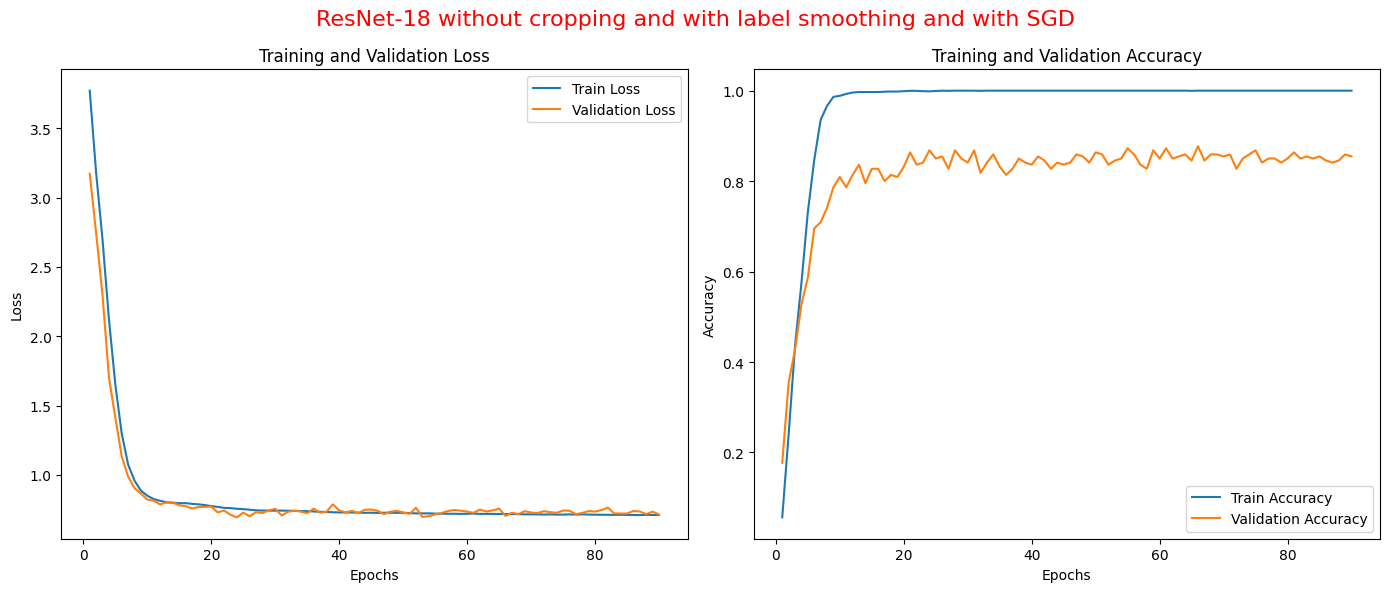

In [ ]:
title = f"ResNet-18 without cropping and with label smoothing and with SGD"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_resnet_no_crop, test_loader, device)

Accuracy of the network on the test images: 91.69%


Overall, the performances seem to be better wrt to the AdamW optimizer, but keep in mind that we used the warm-up structure.
In addition, we can notice that the SGD optimizer tends to be more stable wrt to AdamW, without sudden drop of the validation accuracy.

By the way, the accuracy value obtained is similar to the one obtained with AdamW as optimizer and using only OneCycle as scheduler. Taking into account these performances we could try to mix together those two techniques. So, we want to use SGD as optimizer but reusing OneCycle as scheduler, in order to improve the performances.

### ResNet-18 with label smoothing and SGD optimizer

In this section, as mentioned before, we would like to try to use AdamW as optimizer just using OneCycle scheduler instead of use two different schedulers.

In [ ]:
# Hyperparameters

cfg = {
    "resize_size": 345,
    "crop_size": 224,
    "degrees": 20,

    "batch_size": 296,
    "num_epochs": 30,

    "lr": 1e-3,
    "wd": 1e-4,
    "momentum": 0.9,

    'drop_out_rate': 0.35
}

In [ ]:
tsfms_conv = T.Compose([
    T.ToTensor(),
    T.Resize(size=(cfg['resize_size'], cfg['resize_size'])),  # we put the resize because we have image with different dimensions
    T.Normalize(mean_image_net, std_image_net),
    #T.RandomResizedCrop(cfg['crop_size']),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(cfg['degrees'])
])

In [ ]:
train = GroceryStoreDataset('train', transform=tsfms_conv) # training
val = GroceryStoreDataset('val', transform=tsfms_conv)  # validation
test = GroceryStoreDataset('test', transform=tsfms_conv) # test

paths, labels = train.read_file()
num_classes = train.get_num_classes()

In [ ]:
cfg['batch_size'] = 220

In [ ]:
train_loader = DataLoader(train,
                          batch_size=cfg['batch_size'],
                          shuffle=True,
                          drop_last=True
                          )

val_loader = DataLoader(val,
                        batch_size=cfg['batch_size'],
                        drop_last=True
                        )

test_loader = DataLoader(test,
                         batch_size=cfg['batch_size'],
                         drop_last=True
                         )
print(f'Number of batches in the train set: {len(train_loader)}')
print(f'Number of batches in the val set: {len(val_loader)}')
print(f'Number of batches in the test set: {len(test_loader)}')

Number of batches in the train set: 12
Number of batches in the val set: 1
Number of batches in the test set: 11


In [ ]:
from torchvision import models

# Load the pretrained ResNet-18 model
model_resnet_no_crop = models.resnet18(weights='IMAGENET1K_V1')

# the final fully connected layer to match the number of classes in GroceryStoreDataset
num_ftrs = model_resnet_no_crop.fc.in_features
model_resnet_no_crop.fc = nn.Linear(num_ftrs, num_classes)  # num_classes is the number of classes in your dataset

In [ ]:
cfg['num_epochs'] = 130

In [ ]:
for name, params in model_resnet_no_crop.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [ ]:
torch.cuda.empty_cache()
model_resnet_no_crop.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = torch.optim.SGD(model_resnet_no_crop.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'], momentum=cfg['momentum'])
num_steps = cfg['num_epochs'] * len(train_loader)
scheduler = OneCycleLR(optimizer, cfg['lr'], total_steps=num_steps)

In [ ]:
best_val_acc, best_params, best_epoch, train_losses, train_accuracies, val_losses, val_accuracies = train_loop_ls(model_resnet_no_crop, train_loader, cfg['num_epochs'], optimizer, scheduler, val_loader, verbose=True)

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch 0: train loss 3.817 - train acc 3.52% - valid loss 3.744 - valid acc 5.00%
Epoch 1: train loss 3.764 - train acc 4.85% - valid loss 3.660 - valid acc 5.00%
Epoch 2: train loss 3.683 - train acc 6.82% - valid loss 3.551 - valid acc 10.00%
Epoch 3: train loss 3.586 - train acc 12.95% - valid loss 3.426 - valid acc 16.82%
Epoch 4: train loss 3.488 - train acc 18.41% - valid loss 3.298 - valid acc 20.00%
Epoch 5: train loss 3.383 - train acc 20.45% - valid loss 3.195 - valid acc 21.82%
Epoch 6: train loss 3.295 - train acc 22.01% - valid loss 3.094 - valid acc 24.55%
Epoch 7: train loss 3.203 - train acc 22.69% - valid loss 3.003 - valid acc 28.18%
Epoch 8: train loss 3.121 - train acc 26.82% - valid loss 2.948 - valid acc 31.36%
Epoch 9: train loss 3.034 - train acc 30.49% - valid loss 2.886 - valid acc 36.36%
Epoch 10: train loss 2.943 - train acc 34.96% - valid loss 2.814 - valid acc 35.45%
Epoch 11: train loss 2.855 - train acc 36.70% - valid loss 2.733 - valid acc 35.91%
Epoch 1

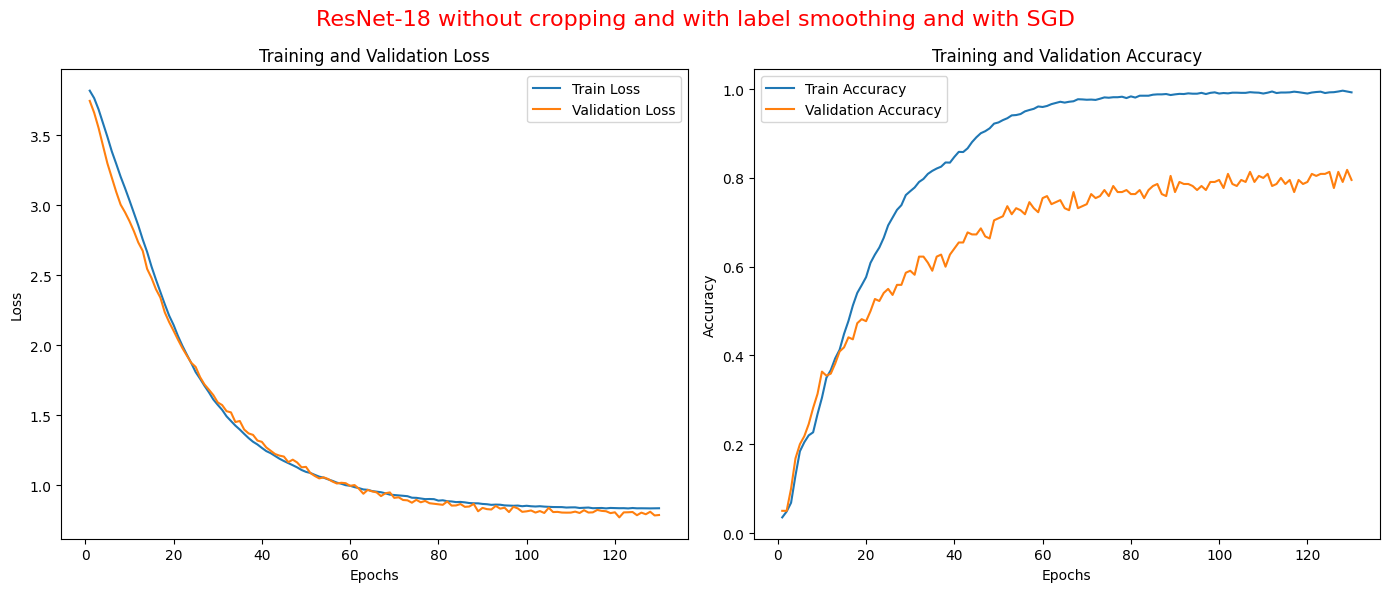

In [ ]:
title = f"ResNet-18 without cropping and with label smoothing and with SGD"
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, title=title)

In [ ]:
test_model(model_resnet_no_crop, test_loader, device)

Accuracy of the network on the test images: 88.84%


It seems that mixing together those two techniques is not a good idea with our hyperparameters. In fact, we onbtained worse results if compared to the previous ones.

Again, we can see that SGD seems to mantain a more constant learning, instead of AdamW which presents some ups and downs during the learning process.

### Final Conclusions for task 2

During the resolution of this task, we first tested ResNet-18 with the best hyperparameters we selected in task 1. (A special mention should be made of dropout, which we could not use on ResNet-18 as it was not permitted.)

In particular, we were extremely fortunate to immediately achieve an accuracy value that fell within the required parameters (between 80% and 90%).

Reassured by the results obtained on the first attempt, we decided to maintain the same parameters from the first task in terms of learning rate and weight decay.

Since we did not intend to conclude task 2 so early, we decided to change some aspects of the training recipe.

What we aimed to try was to test the behavior of ResNet-18 in the presence of cropping. In fact, during task 1, we noticed that cropping led our model to achieve worse results. Consequently, we tested ResNet-18 with the hyperparameters from task 1, first implementing cropping in the transformer and then removing it. As in task 1, we observed that without cropping, the model was able to reach higher accuracies (very close to 90%).

Confident from having already achieved excellent results, we wondered how to modify the training recipe to obtain even better results. In particular, we found evidence that implementing label smoothing in the cross-entropy function could be a good idea. We considered this technique interesting because we had not used it during task 1. Label smoothing proved to be extremely effective, raising accuracy levels by about 3% and thus pushing the values beyond 90% accuracy.

At this point, we questioned the nature of the scheduler we had chosen as the best scheduler in the solution for task 1. In fact, considering what we studied in the theoretical part of the course regarding regularization and training recipes, we wanted to try using a warm-up period instead of OneCycle.

While testing the use of two different schedulers instead of OneCycle, we realized that SGD as an optimizer performed better than AdamW when used with the two schedulers.

To make a fair comparison between the two optimizers (SGD and AdamW), we decided to test the use of SGD with OneCycle as the scheduler. The results obtained were slightly worse compared to those obtained with AdamW and OneCycle.

In conclusion, the training recipe that seems to lead us to achieve the best results overall, with ResNet-18 on our dataset, is: using label smoothing without cropping, AdamW as the optimizer associated with OneCycle as the scheduler. Meanwhile, the hyperparameters used are the same ones selected for task 1: a learning rate of 0.001 and a weight decay of 0.0001.